# **Data Porter - Customer Churn Prediction**

# **Business: Telecommunication Company -  Customer Churn Rate**

## **Problem Statement**

Our telco company is facing a growing problem of customer churn. Churn refers to the phenomenon where customers terminate their subscriptions and switch to competitors or discontinue service entirely. Churn is a significant issue for our company as it results in lost revenue and increased costs associated with acquiring new customers.

## **Goals**

Develop a predictive model to proactively identify high-risk churn customers, enabling us to implement retention strategies effectively.

## **Objectives**

*   Identify Key Churn Factors: Analyze historical customer data to identify the critical variables and factors that have a significant influence on customer churn. These may include factors such as service usage patterns, customer demographics, customer support interactions, billing issues, and contract terms.

*   Predictive Modeling: Develop a predictive model that can estimate the probability of churn for each customer. The model should utilize historical data to make predictions about whether a new customer is at risk of churning within a specified time frame.

*   Feature Importance: Determine which customer attributes or behaviors contribute the most to churn risk, enabling the company to focus on targeted interventions to retain at-risk customers.

*   Monitoring and Evaluation: Churn rate and predictive model performance monitoring and evaluation.

*   Recommendations: Provide actionable recommendations based on the analysis and modeling results. These recommendations should include strategies for reducing churn, improving customer experience, and enhancing customer loyalty.

## **Metrics**

Business: <br>
**Churn Rate (%)**

<br>

Machine Learning Model:
*   F1 Score: This metric combines precision and recall and is particularly useful when dealing with imbalanced datasets. A higher F1 score is better.
*   ROC AUC: ROC AUC measures the area under the Receiver Operating Characteristic curve, which is useful for binary classification. A higher ROC AUC indicates better model discrimination.
*    Loss: Log loss measures the accuracy of the predicted probabilities. Lower log loss is better.





# **1. Preparation**

The libraries used will be listed below.

In [ ]:
!pip install optuna

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.1 MB/s eta 0:00:00


In [ ]:
# Data Exploration
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

# Correlation and Relationship
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import pointbiserialr

# Feature Preprocessing and Engineering
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE #SMOTE Oversampler
from sklearn.model_selection import train_test_split #Data Splitting
from sklearn.preprocessing import MinMaxScaler #Data Normalization

# Machine Learning Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Model Evaluation Metrics
from sklearn.metrics import f1_score, roc_auc_score, log_loss
from sklearn.model_selection import KFold, cross_val_predict
from mlxtend.evaluate import bias_variance_decomp

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
# import optuna

In [ ]:
df = pd.read_csv('Telco_customer_churn_adapted_v2.csv', sep=';')
df.sample(5)

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
3666,3666,59,Jakarta,High End,Yes,Yes,Yes,No,No,No,Credit,"107,835",No,"106,81667","-6,20000","6883,5"
387,387,13,Jakarta,High End,No,No,No,No,No,No,Credit,"96,72",Yes,"106,81667","-6,20000","4793,1"
6811,6811,13,Jakarta,High End,No,No,No,Yes,Yes,Yes,Pulsa,"130,975",No,"106,81667","-6,20000","7780,5"
3097,3097,8,Jakarta,High End,No,No,No,No,No,No,Credit,"96,98",No,"106,81667","-6,20000","2784,6"
886,886,1,Jakarta,High End,No,No,No,No,Yes,Yes,Pulsa,"123,63",Yes,"106,81667","-6,20000","7533,5"


# **2. Exploratory Data Analysis**

## **i. Univariate Analysis**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Customer ID                   7043 non-null   int64 
 1   Tenure Months                 7043 non-null   int64 
 2   Location                      7043 non-null   object
 3   Device Class                  7043 non-null   object
 4   Games Product                 7043 non-null   object
 5   Music Product                 7043 non-null   object
 6   Education Product             7043 non-null   object
 7   Call Center                   7043 non-null   object
 8   Video Product                 7043 non-null   object
 9   Use MyApp                     7043 non-null   object
 10  Payment Method                7043 non-null   object
 11  Monthly Purchase (Thou. IDR)  7043 non-null   object
 12  Churn Label                   7043 non-null   object
 13  Longitude         

There are no missing values in the data.

In [ ]:
print(f'There are {df.duplicated().sum()} duplicates in the dataset.')

There are 0 duplicates in the dataset.


In [ ]:
# Convert the 'Monthly Purchase (Thou. IDR)' and 'CLTV (Predicted Thou. IDR)' columns to numerical data
df['Monthly Purchase (Thou. IDR)'] = df['Monthly Purchase (Thou. IDR)'].str.replace(',', '.').astype(float)
df['CLTV (Predicted Thou. IDR)'] = df['CLTV (Predicted Thou. IDR)'].str.replace(',', '.').astype(float)

In [ ]:
# Split Numerical and Categorical Features
# Define empty lists to save names of numerical and categorical columns
numerical_features = []
categorical_features = []

# Iterate through columns and classify features
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        numerical_features.append(column)
    else:
        categorical_features.append(column)


numerical_features.remove('Customer ID')
categorical_features.remove('Longitude')
categorical_features.remove('Latitude')

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['Tenure Months', 'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)']
Categorical Features: ['Location', 'Device Class', 'Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp', 'Payment Method', 'Churn Label']


### **a. Numerical**

In [ ]:
df[numerical_features].describe()

,Tenure Months,Monthly Purchase (Thou. IDR),CLTV (Predicted Thou. IDR)
count,7043.000000,7043.000000,7043.000000
mean,32.371149,84.190200,5720.384481
std,24.559481,39.117061,1537.974298
min,0.000000,23.725000,2603.900000
25%,9.000000,46.150000,4509.700000
50%,29.000000,91.455000,5885.100000
75%,55.000000,116.805000,6994.650000
max,72.000000,154.375000,8450.000000


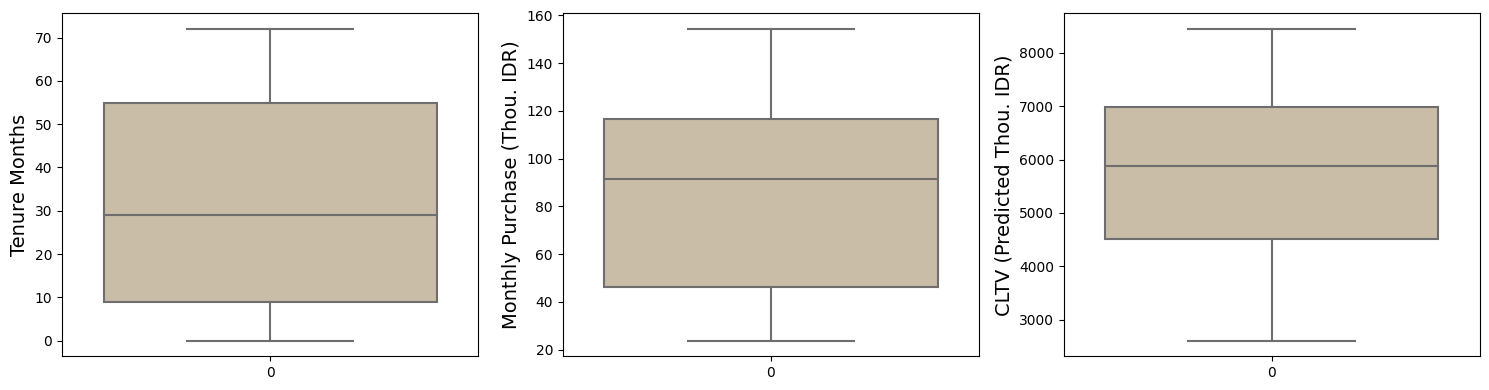

In [ ]:
# Boxplot for these numerical features
plt.figure(figsize=(15,4))
for i in range(0, len(numerical_features)):
    plt.subplot(1, 3, i+1)
    sb.boxplot(df[numerical_features[i]], color='#CEBFA2')
    plt.ylabel(numerical_features[i], fontsize=14)
    plt.tight_layout()
plt.show()

There are no outliers in the data.

In [ ]:
# Checking normality of the continuous numerical features using the Kolmogorov-Smirnov test.

for feat in numerical_features[1:]:
    data = np.array(df[feat])
    kstest_statistic, kstest_pvalue = stats.kstest(data, 'norm')
    if kstest_pvalue < 0.05:
        print(f"The distribution of the {feat} features is not normal. The kstest score is: {kstest_pvalue}")
    else:
        print("The distribution of the {feat} feature is normal. The kstest score is: {kstest_pvalue}")

The distribution of the Monthly Purchase (Thou. IDR) features is not normal. The kstest score is: 0.0
The distribution of the CLTV (Predicted Thou. IDR) features is not normal. The kstest score is: 0.0


We are incorporating the Kolmogorov-Smirnov test as a supplementary tool for our visualization analysis below. It's important to note that this statistical test is not applicable to discrete data, such as 'Tenure Months.' Therefore, we are exclusively applying it to assess the continuous data.

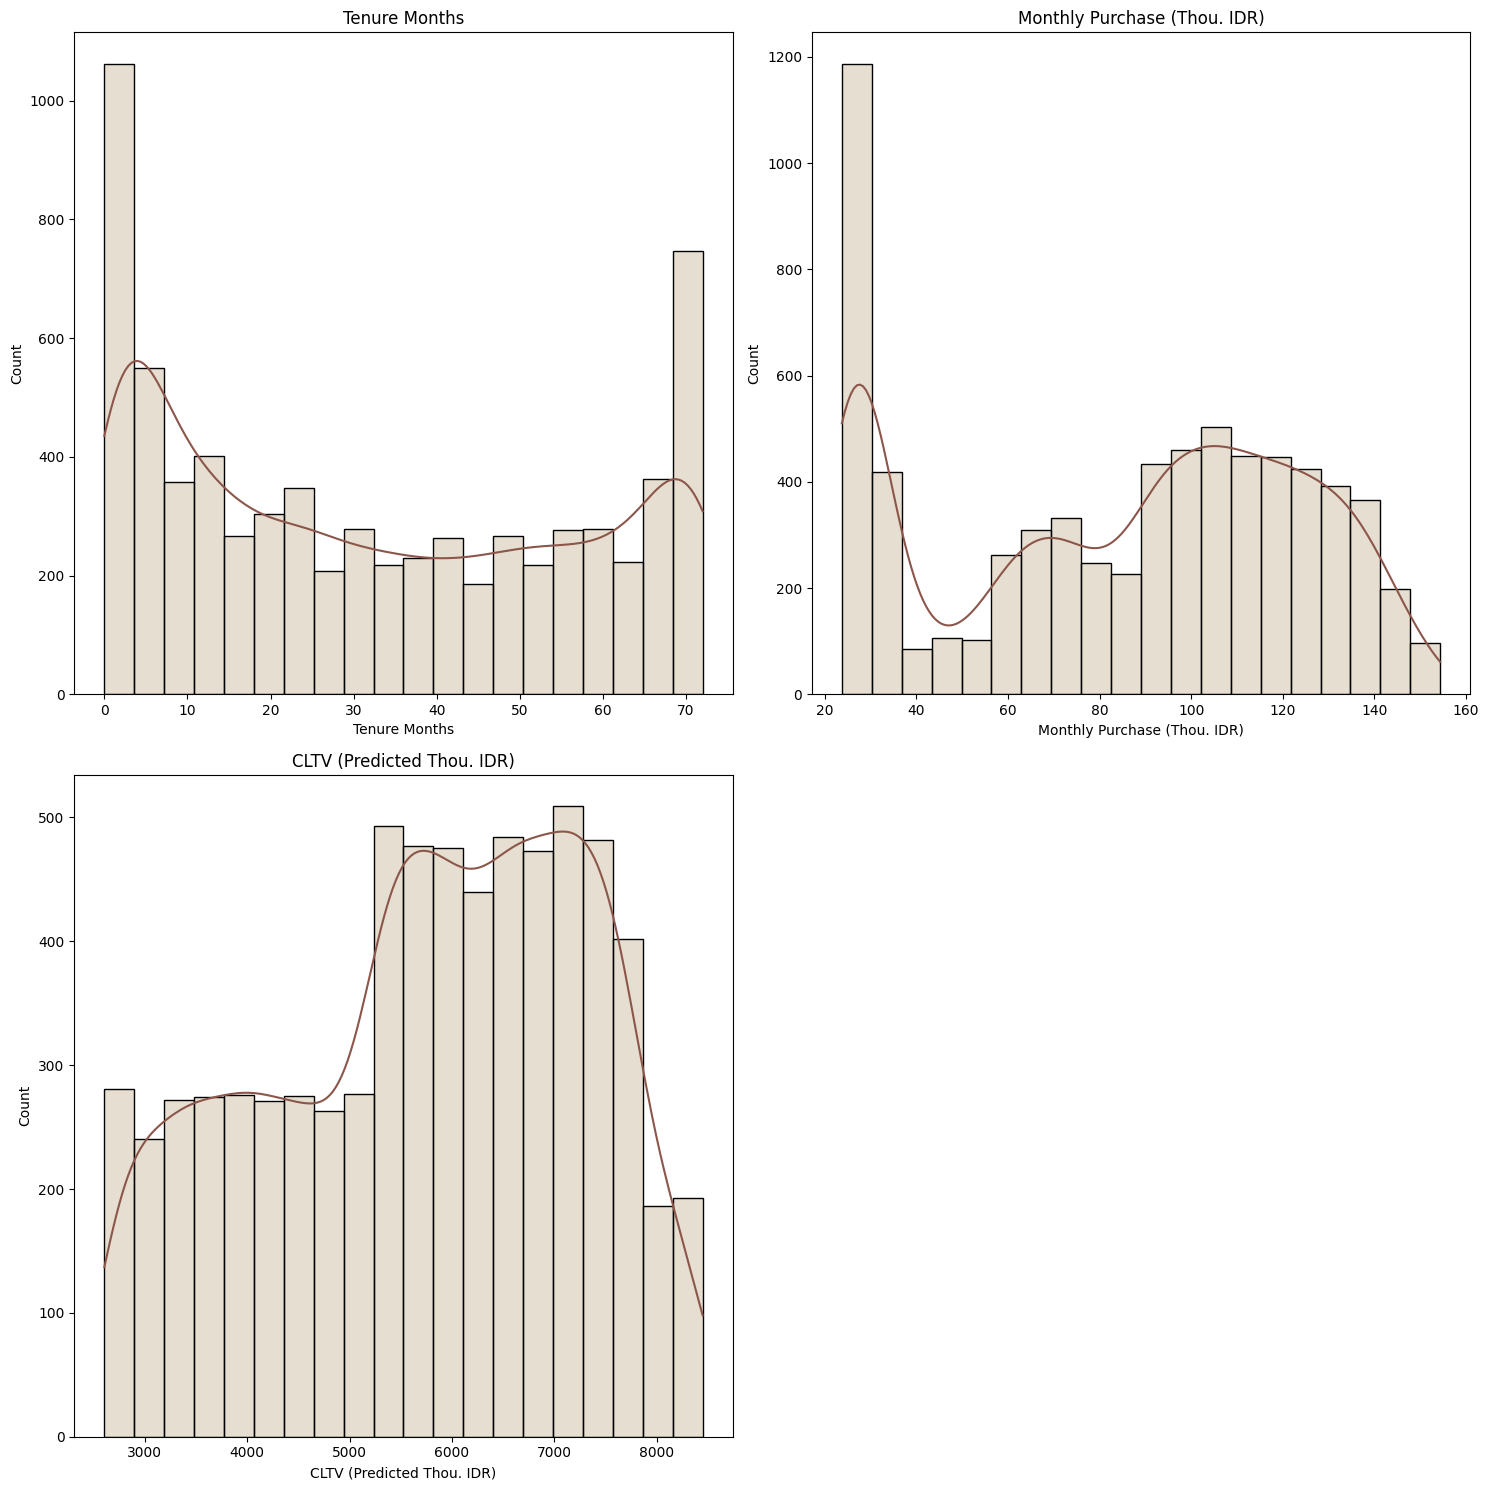

In [ ]:
# Histogram subplot for numerical features with KDE
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
for i in range(len(numerical_features)):
    ax = sb.histplot(data=df, x=numerical_features[i], color='#CEBFA2', bins=20, kde=True, ax=axs[i//2, i%2])
    ax.lines[0].set_color('tab:brown')  # Set the color of the KDE line to brown
    axs[i//2, i%2].set_title(numerical_features[i])

fig.delaxes(axs[1, 1])
plt.tight_layout()
plt.show()

In [ ]:
df[numerical_features].skew()

Tenure Months                   0.239540
Monthly Purchase (Thou. IDR)   -0.220524
CLTV (Predicted Thou. IDR)     -0.311602
dtype: float64

Based on the visualization analysis of the numerical features, it can be concluded that:

<ul>
  <li>The "Tenure Months" feature does not follow a normal distribution; it exhibits right-skewness. The customer tenures range from 0 to 80 months, with the highest concentration occurring within the first 10 months and again between 60 and 80 months.</li>
</ul>

Based on the results of the Kolmogorov-Smirnov normality test and a thorough visual analysis of the numerical features, we can confidently draw the following conclusions:

<ul>
  <li>The "Monthly Purchase" feature also departs from a normal distribution, displaying left-skewness. Customer monthly purchases range from Rp20,000 to Rp160,000. Notably, nearly 1,200 users fall within the range of Rp20,000 to Rp30,000 in their monthly spending. However, the distribution is skewed to the left due to the significant number of users whose spending falls within the range of Rp90,000 to Rp140,000 per month, eclipsing the lower-spending group.</li>
  <li>The "CLTV" (Customer Lifetime Value) feature also shows a left-skewness. The values range from Rp2.000.000 to Rp9.000.000, with the majority of customers falling within the range of Rp5.000.000 to Rp8.000.000 for their lifetime value.</li>
</ul>

### **b. Categorical**

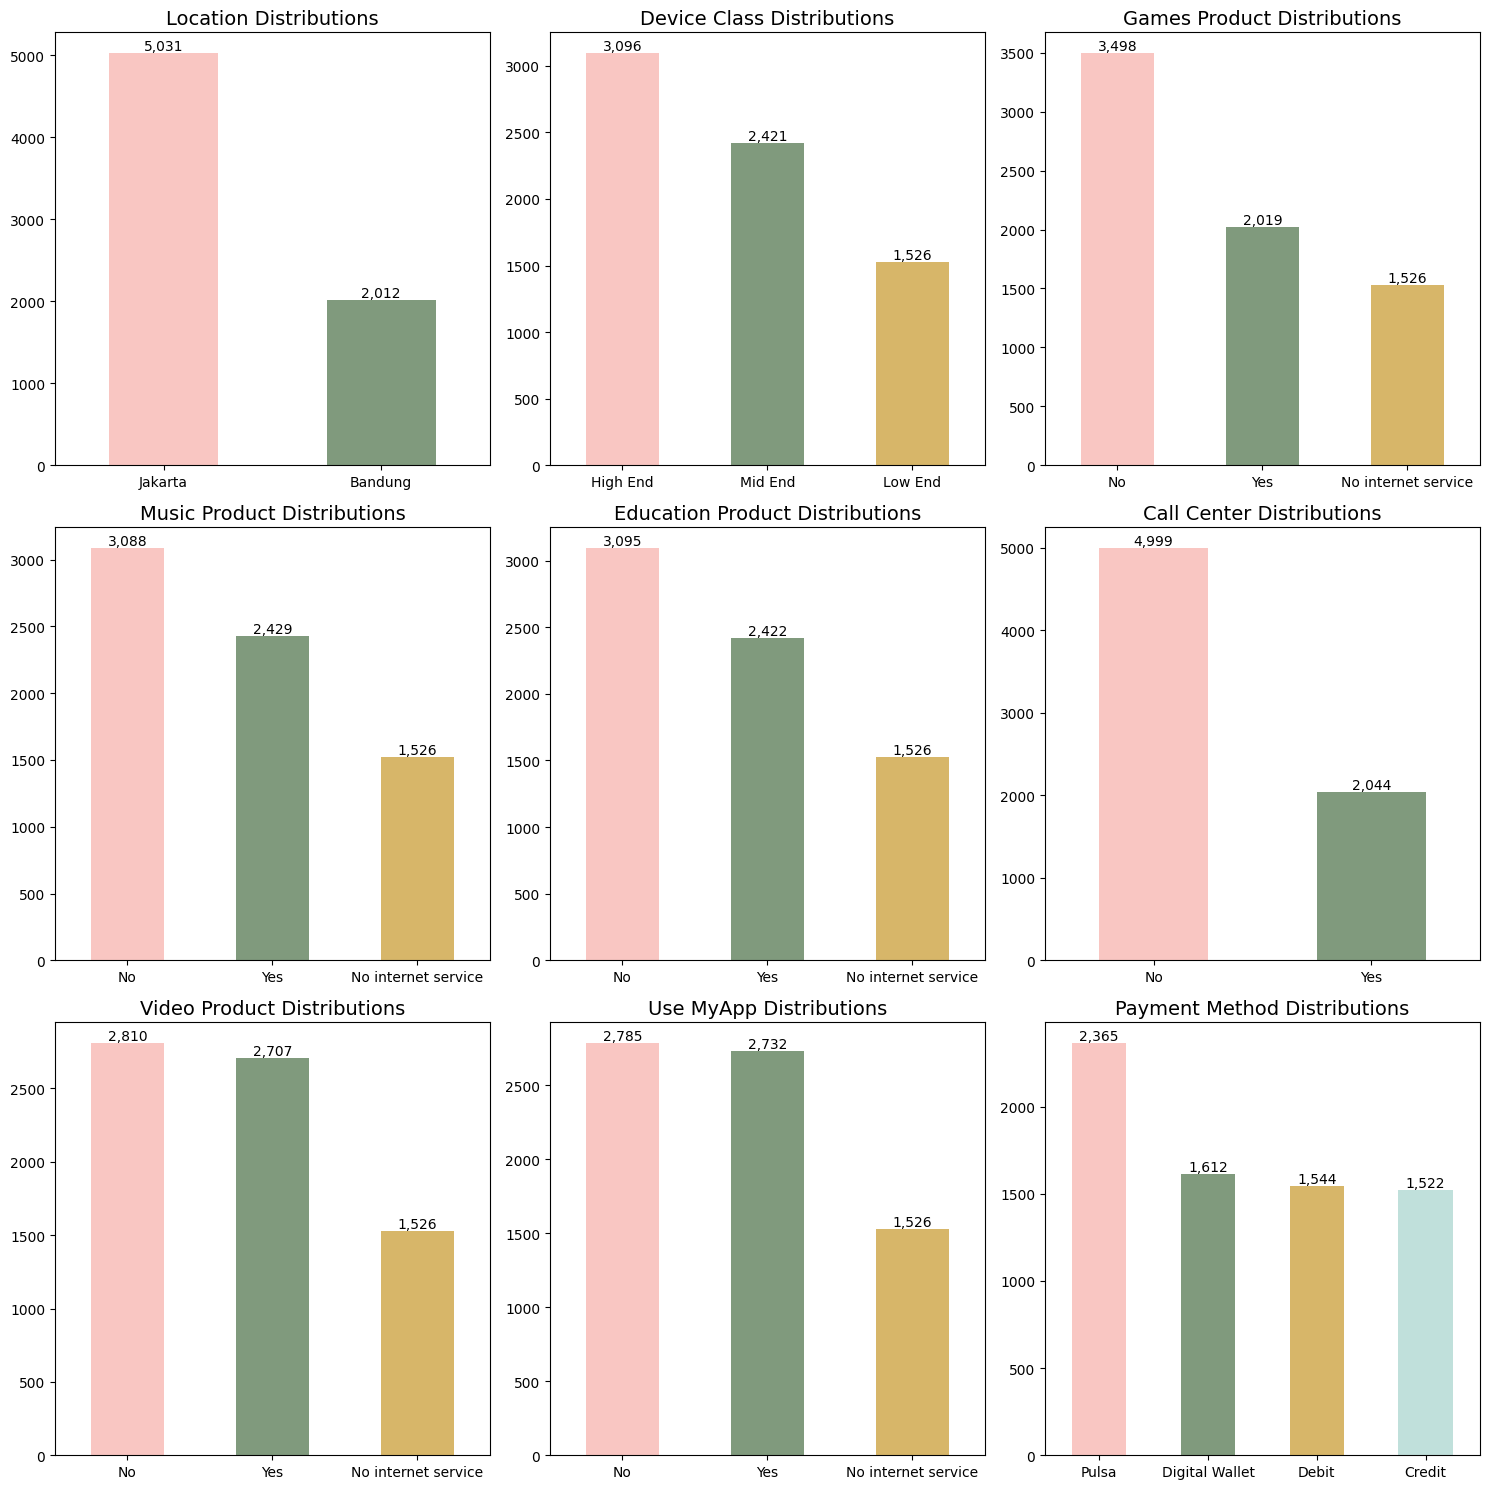

In [ ]:
# Visualizing Categorical Features
selected_features = categorical_features[:9]

# Define the list of distinct colors
colors = ['#F9C6C2', '#809A7D', '#D7B669', '#C0E0DB']

plt.figure(figsize=(15, 15))

for i in range(0, len(selected_features)):
    plt.subplot(3, 3, i + 1)
    counts = df[selected_features[i]].value_counts()

    # Assign colors to categories based on the order of the colors list
    category_colors = [colors[j % len(colors)] for j in range(len(counts))]

    counts.plot(kind='bar', color=category_colors)
    plt.title(selected_features[i] + ' Distributions', fontsize=14)
    plt.xticks(rotation=0)

    # Add bar labels
    for j, count in enumerate(counts):
        formatted_count = '{:,.0f}'.format(count)  # Format count with a comma separator
        plt.text(j, count, formatted_count, ha='center', va='bottom')

    plt.tight_layout()

plt.show()

From the visualization, we can conclude that:

<ul>
  <li>The majority of our customers are from Jakarta, and interestingly, most of them don't actively engage with the company's offerings, including its games, music, education, and video products, as well as the mobile application. Moreover, a significant portion of them has never reached out to our customer service call center.</li>
  <li>When it comes to their device preferences, we observe a clear pattern. Most of our customers opt for high-end devices, followed by those in the mid-end device class. In contrast, the low-end device class attracts the smallest share of our clientele.</li>
  <li>In terms of payment methods, the credit option stands out as the preferred choice among our customers, with digital wallets being the second most popular. Debit cards come next in line, followed by credit card payments as the least favored option.</li>
</ul>

Cleanings to do:

<ul>
  <li>Modify the "No Internet Service" category to "No" in 'Games Product,' 'Music Product,' 'Education Product,' 'Video Product,' and 'Use MyApp.' This change eliminates redundancy by indicating that the customer did not use the products. Furthermore, it helps ensure the fairness and accuracy of the forthcoming chi-squared test in our Multivariate analysis, as a consistent count of "No Internet Service" across columns can introduce bias.</li>
  <li>Transform the 'Location' column into 'is_Jakarta,' and reassign "Jakarta" to "Yes" and "Bandung" to "No." This adjustment converts the variable into a binary format, offering a more straightforward representation.</li>
</ul>

We're going to do these cleanings before doing the categorical multivariate analysis.

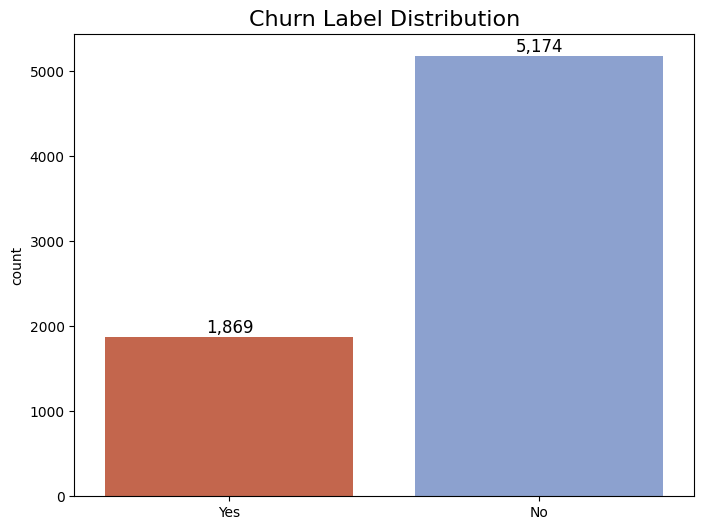

In [ ]:
# Visualizing the Target Feature
plt.figure(figsize=(8, 6))
ax = sb.countplot(data=df, x='Churn Label', palette={'No': '#819DDA', 'Yes': '#D75B39'})

# Add bar labels without the .0
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

# Set the title at the top center with 'Distribution' added
plt.title('Churn Label Distribution', fontsize=16, loc='center')

# Remove the x-axis label (Churn Label)
ax.set_xlabel('')

plt.show()

From this target feature visualization, we can say that while the majority of our customers remain loyal, it's important to note that the number of churned customers is also significant.

<br>

The count plot of our target feature clearly illustrates the existing class imbalance. This indicates the need for addressing this imbalance during the preprocessing sta

## **ii. Bivariate Analysis**

### **a. Numerical**

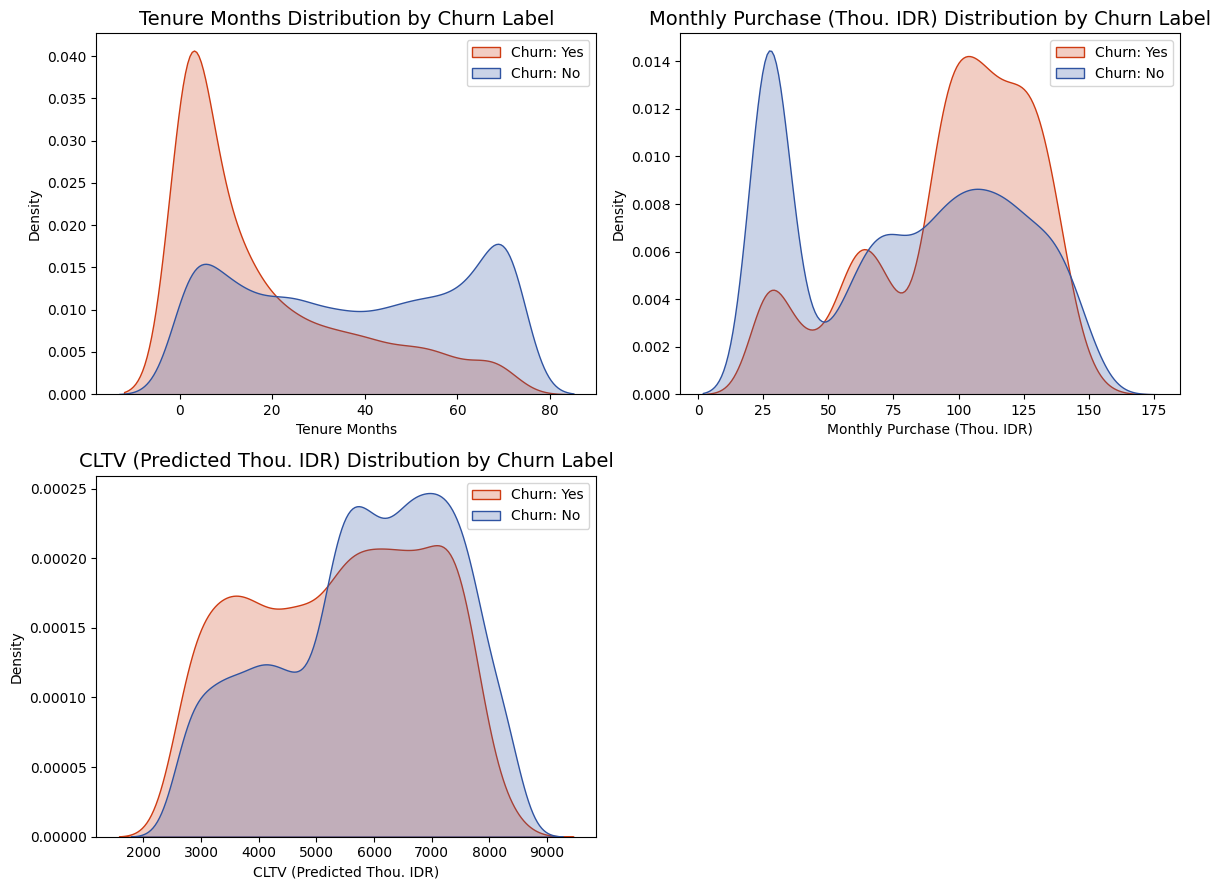

In [ ]:
# KDE Plot for numerical features
num_features = len(numerical_features)

# Initialize the row-wise subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, num_features*3))

for i in range(0, num_features):
    # Use i-th subplot
    sb.kdeplot(df[df['Churn Label'] == 'Yes'][numerical_features[i]], color='#CE3B12', label='Churn: Yes', fill=True, ax=axs[i // 2, i % 2])
    sb.kdeplot(df[df['Churn Label'] == 'No'][numerical_features[i]], color='#2F53A1', label='Churn: No', fill=True, ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(numerical_features[i] + ' Distribution by Churn Label', fontsize=14)
    axs[i // 2, i % 2].legend(loc='upper right')

fig.delaxes(axs[1, 1])
plt.tight_layout()
plt.show()

From this visualization, we can see that:
<ul>
  <li>Tenure Months: The churn of the customers is mainly focused on the customers who have been using our service for less than 10 months.</li>
  <li>Monthly Purchase (Thou. IDR): Most of the churning customers are high spenders, with monthly purchases of around RP 90,000 to Rp 135,000.</li>
  <li>CLTV (Predicted Thou. IDR): The churning customers are the ones with the CLTV (Customer Lifetime Values) of around RP 3,000,000 to RP 7,500,000.</li>

In [ ]:
df_eda = df.copy()

# Convert 'No Internet Service' category to 'No' in the selected columns
columns_to_convert = ['Games Product', 'Music Product', 'Education Product','Video Product']

for column in columns_to_convert :
    df_eda[column] = df_eda[column].replace('No internet service', 'No')

# Split churn and no churn data
churn = df_eda[df_eda['Churn Label'] == 'Yes']
not_churn = df_eda[df_eda['Churn Label'] != 'Yes']

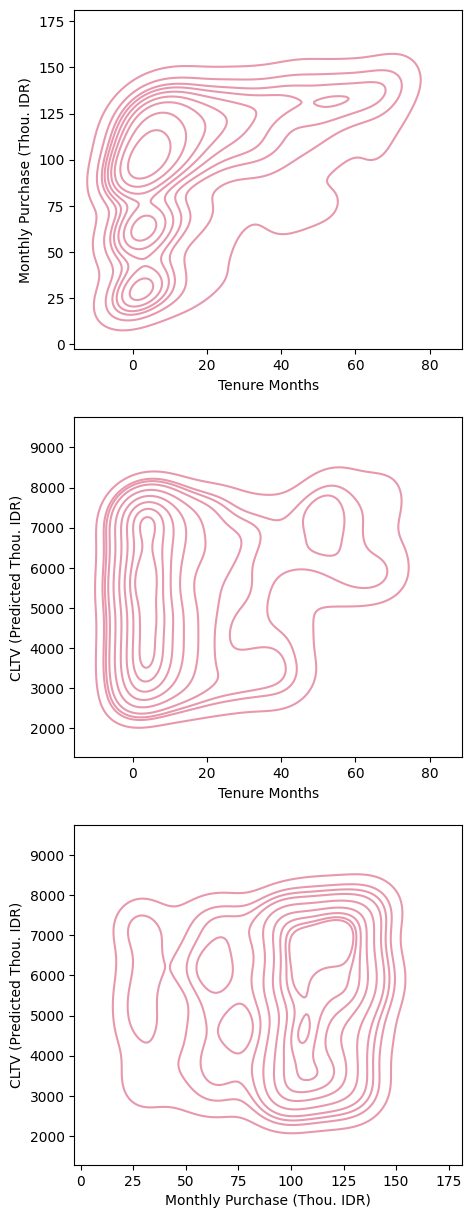

In [ ]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(5, 15))

# Create the three KDE plots
sb.kdeplot(data=churn, x="Tenure Months", y="Monthly Purchase (Thou. IDR)", color = '#e898ac', ax=axes[0])
sb.kdeplot(data=churn, x="Tenure Months", y="CLTV (Predicted Thou. IDR)", color = '#e898ac', ax=axes[1])
sb.kdeplot(data=churn, x="Monthly Purchase (Thou. IDR)", y="CLTV (Predicted Thou. IDR)", color = '#e898ac', ax=axes[2])

# Show the plots
plt.show()

### **b.Categorical**

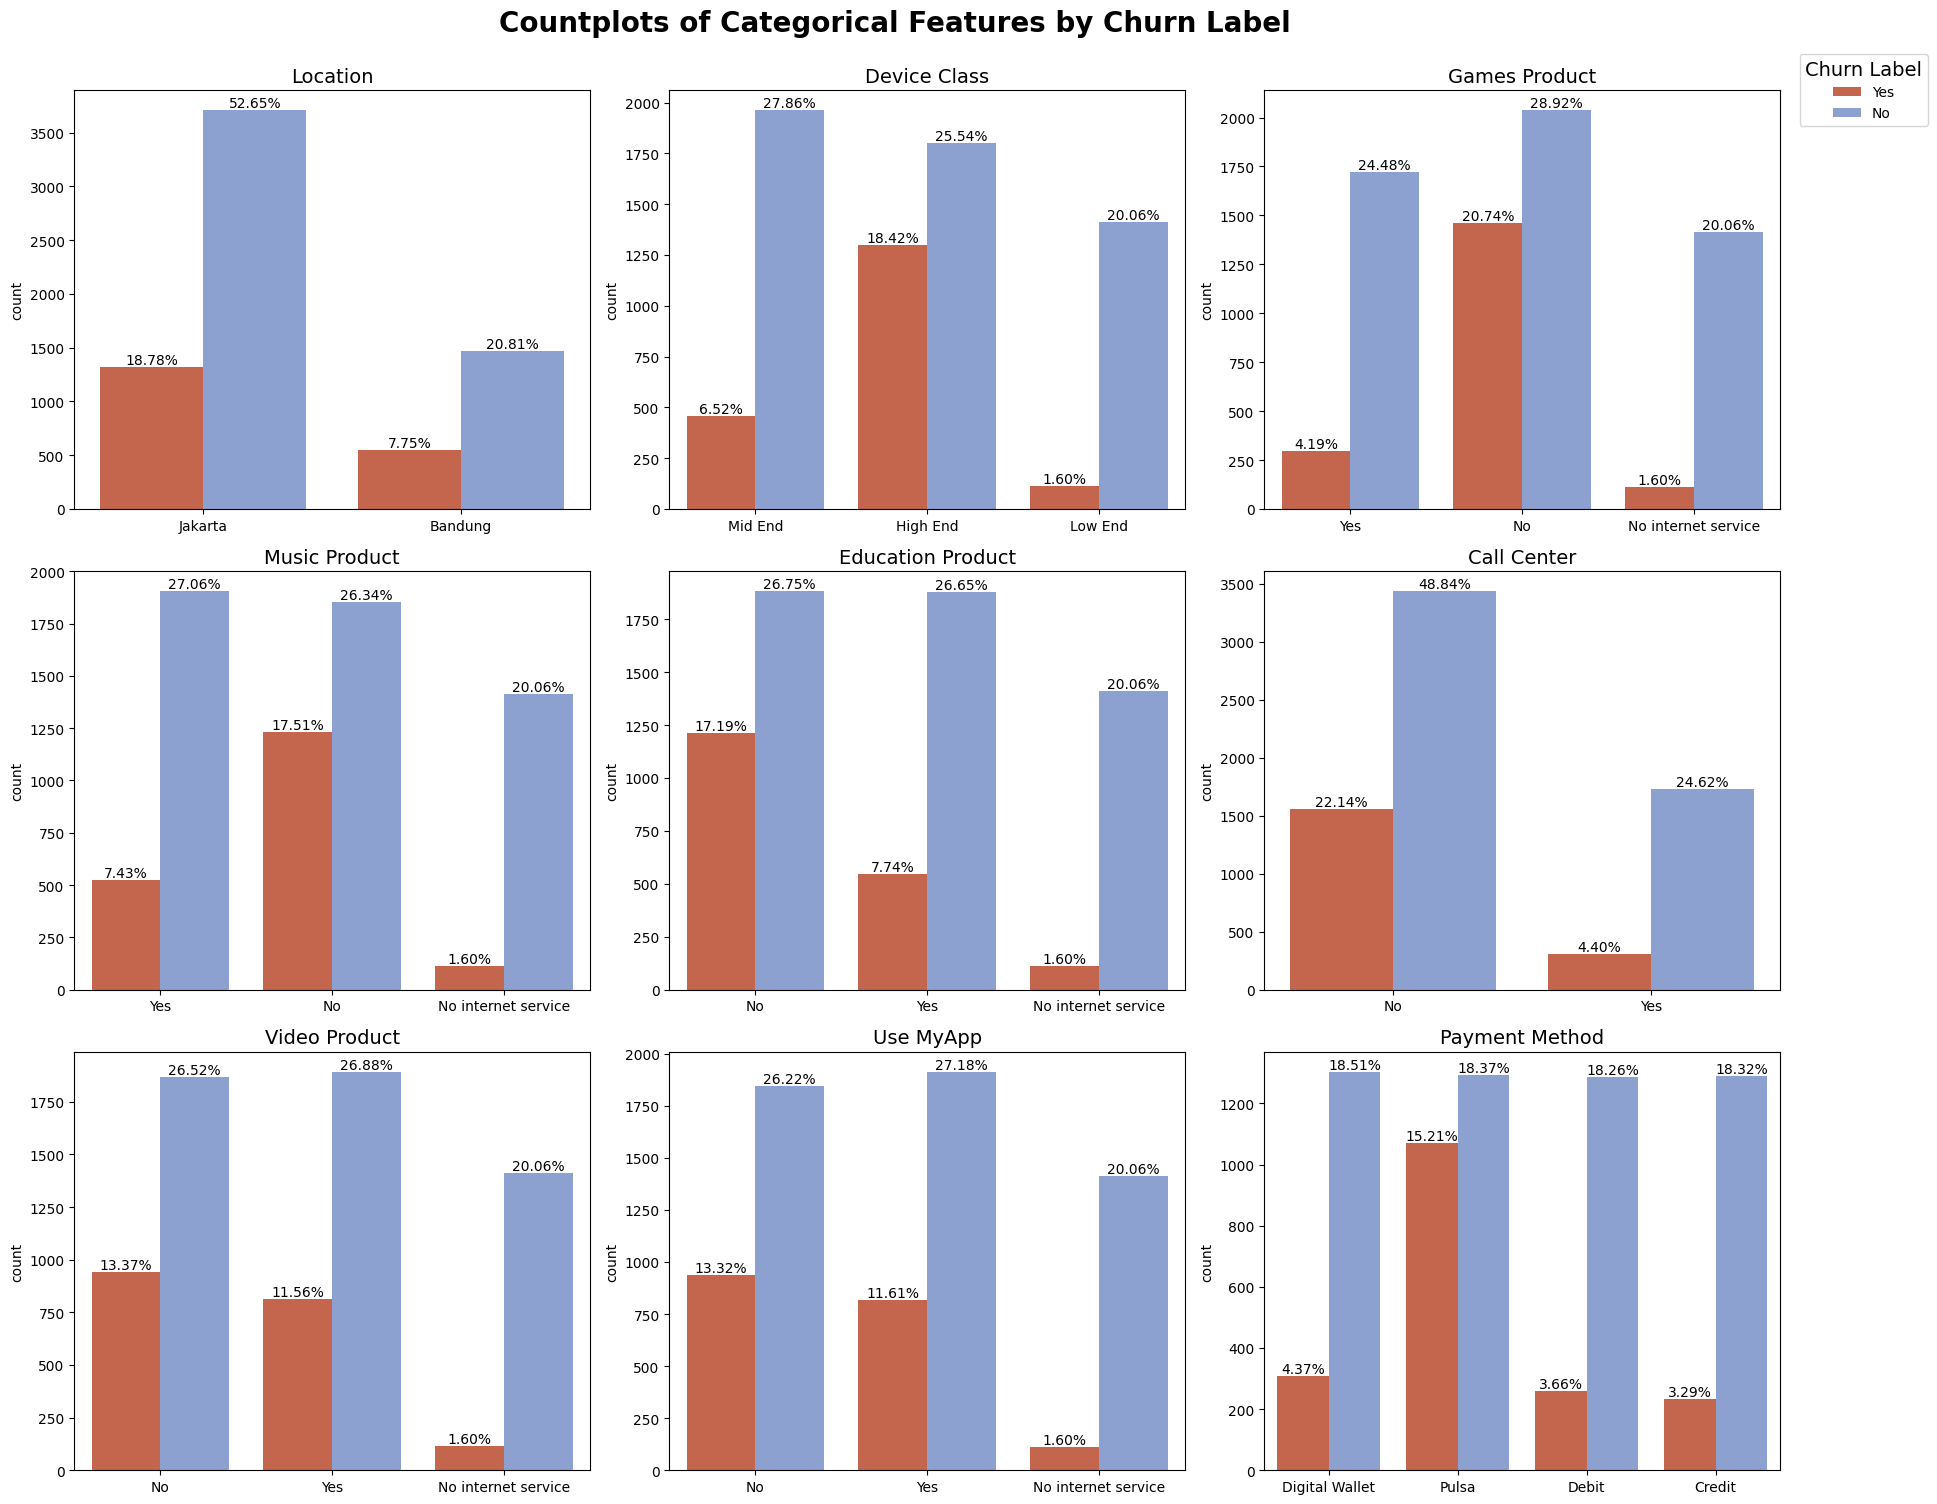

In [ ]:
selected_features = categorical_features[:9]

plt.figure(figsize=(18, 15))
plt.suptitle('Countplots of Categorical Features by Churn Label', fontsize=20, fontweight='bold', x=0.5, y=1)  # Add the overall title

# Create an empty list to collect the handles (legend items) and labels
legend_handles = []

for i in range(0, len(selected_features)):
    plt.subplot(3, 3, i + 1)
    ax = sb.countplot(data=df, x=selected_features[i], hue='Churn Label', palette={'Yes': '#D75B39', 'No': '#819DDA'})
    plt.title(selected_features[i], fontsize=14)
    plt.xticks(rotation=0)

    # Add formatted percentage labels on top of each bar
    total = len(df)  # Total count for calculating percentages
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = height / total * 100
        formatted_percentage = f'{percentage:.2f}%'
        ax.annotate(formatted_percentage, (x + width / 2, y + height), ha='center', va='bottom')

    # Get the handles and labels from the first subplot and add them to the legend_handles list
    if i == 0:  # Only for the first subplot
        handles, labels = ax.get_legend_handles_labels()
        legend_handles.extend(handles)

    # Remove the individual subplot legends
    ax.get_legend().remove()
    ax.set_xlabel('')

plt.tight_layout()

# Show a single legend outside the subplots with customized colors for 'Yes' and 'No'
legend = plt.legend(handles=legend_handles, labels=['Yes', 'No'], title='Churn Label', title_fontsize='14', loc='upper right', bbox_to_anchor=(1.3, 3.4))
plt.show()

From the visualization, it can be concluded that:

<ul>
  <li>Location: Compared to Bandung, Jakarta has a higher churning rate of 18.78%.</li>
  <li>Device Class: The customers with the high-end device have the highest churning rate of 18.42%, follow by customers with middle-end device with the churn rate of 6.52%.</li>
  <li>Games Product: The customers who do not utilize the company's games product have a notably higher churn rate of 20.74%.</li>
  <li>Music Product: The customers who do not utilize the company's music product have a notably higher churn rate of 17.51%.</li>
  <li>Education Product: The customers who do not utilize the company's education product have a notably higher churn rate of 17.19%.</li>
  <li>Call Center: The customers without prior call center usage experience have a higher churn rate of 22.14%.</li>
  <li>Video Product: Both the customers who do or do not utilize the company's video product have a high churn rate, where the customers who do not utilize the company's video product have a slightly higher churn rate of 13.37% compared to the one who do ( 11.56%).</li>
  <li>Use MyApp: Both the customers who do or do not use MyApp have a high churn rate, where the customers who do not utilize the company's video product have a slightly higher churn rate of 13.32% compared to the one who do (11.61%).</li>
  <li>Payment Method: The customers using Pulsa as the payment method have the highest churn rate of 15.21%.</li>
</ul>

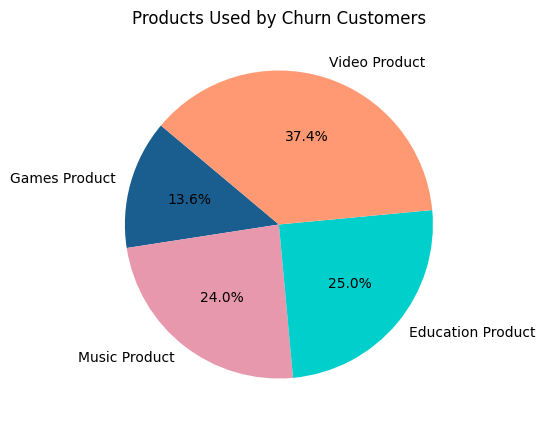

In [ ]:
# What products does the churn customer use?
# Create a dictionary to store the totals
totals = {
    'Games Product': churn['Games Product'].eq('Yes').sum(),
    'Music Product': churn['Music Product'].eq('Yes').sum(),
    'Education Product': churn['Education Product'].eq('Yes').sum(),
    'Video Product': churn['Video Product'].eq('Yes').sum()
}

# Convert the dictionary to a DataFrame
totals_products = pd.DataFrame(totals.items(), columns=['Product', 'Total Yes'])

# Customize the colors for each product
colors = ['#1a5e8f', '#e898ac', '#00cfcc', '#ff9973']

# Extract data for the pie chart
products = totals_products['Product']
totals = totals_products['Total Yes']

# Create a pie chart with custom colors
plt.figure(figsize=(5, 5))
plt.pie(totals, labels=products, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Products Used by Churn Customers')

# Show the pie chart
plt.show()

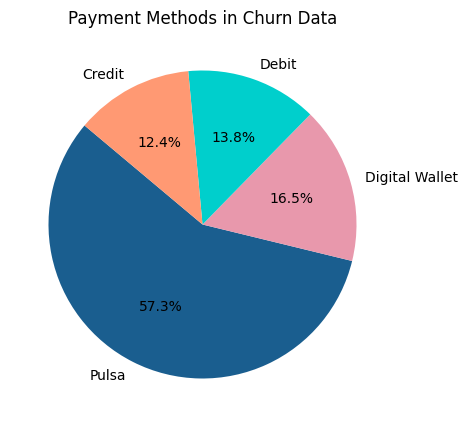

In [ ]:
# Calculate the count of each payment method
payment_counts = churn['Payment Method'].value_counts()

# Customize the colors for each product
colors = ['#1a5e8f', '#e898ac', '#00cfcc', '#ff9973']

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Payment Methods in Churn Data')

plt.show()

<ipython-input-28-98312aad9d13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['Products Used'] = churn[['Games Product', 'Music Product', 'Education Product', 'Video Product']].apply(lambda row: row.eq('Yes').sum(), axis=1)


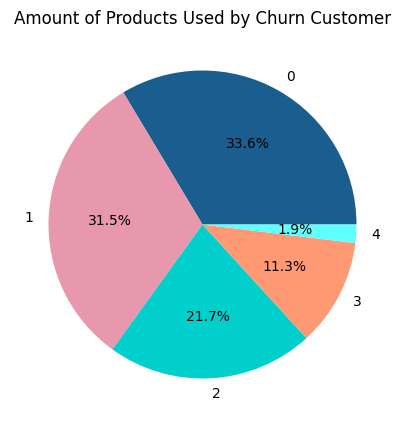

In [ ]:
# Create 'Products Used' column
churn['Products Used'] = churn[['Games Product', 'Music Product', 'Education Product', 'Video Product']].apply(lambda row: row.eq('Yes').sum(), axis=1)

# Customize the colors for each product
colors = ['#1a5e8f', '#e898ac', '#00cfcc', '#ff9973', '#5efffd']

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(churn['Products Used'].value_counts(), labels=churn['Products Used'].value_counts().index, autopct='%1.1f%%', colors=colors)
plt.title('Amount of Products Used by Churn Customer')

plt.show()

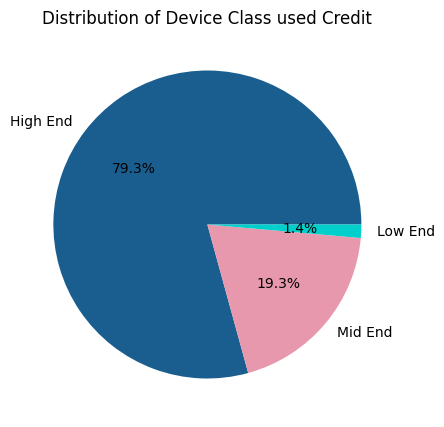

In [ ]:
pulsa = churn[churn['Payment Method'] == 'Pulsa']

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(pulsa['Device Class'].value_counts(), labels=churn['Device Class'].value_counts().index, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Device Class used Credit')

plt.show()

People that used 'Pulsa' as the payment method are from a high device class.

<ipython-input-30-14d9dc1100c9>:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sb.stripplot(x = 'Device Class', y ='Monthly Purchase (Thou. IDR)', data = df_eda, palette=custom_palette, order=['Low End', 'Mid End', 'High End'])


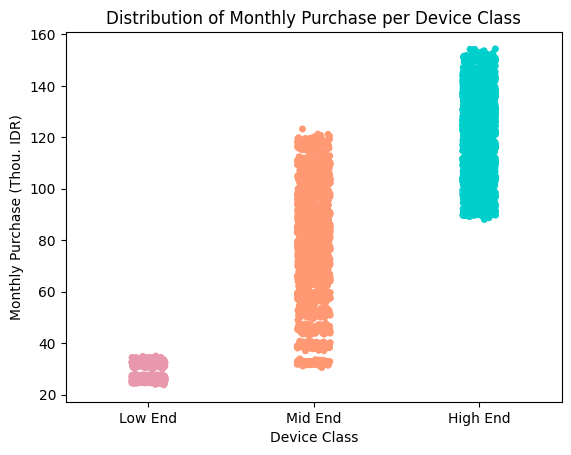

In [ ]:
# Is high device class means high monthly purchase?

custom_palette = ['#e898ac', '#ff9973', '#00cfcc']

sb.stripplot(x = 'Device Class', y ='Monthly Purchase (Thou. IDR)', data = df_eda, palette=custom_palette, order=['Low End', 'Mid End', 'High End'])

plt.title('Distribution of Monthly Purchase per Device Class')
plt.show()

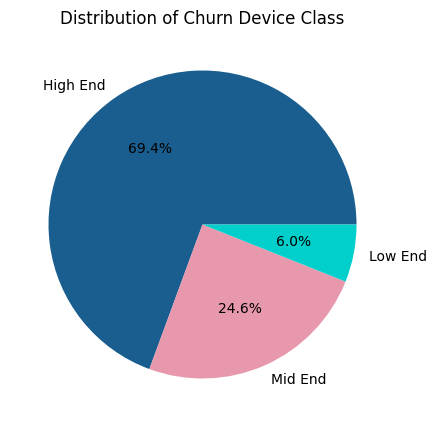

In [ ]:
# What device class churn the most?
# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(churn['Device Class'].value_counts(), labels=churn['Device Class'].value_counts().index, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Churn Device Class')

plt.show()

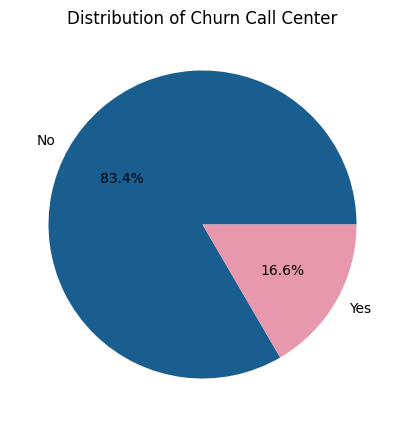

In [ ]:
# Did the churn customers ever called the call center?

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(churn['Call Center'].value_counts(), labels=churn['Call Center'].value_counts().index, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Churn Call Center')

plt.show()

<ipython-input-33-4eb183a2ec3f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['Use MyApp'] = churn['Use MyApp'].replace('No internet service', 'No')


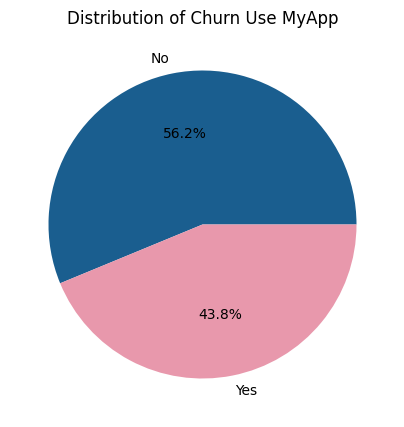

In [ ]:
# Did the churn customer used MyApps
# Convert 'No Internet Service' category to 'No' in the selected columns
churn['Use MyApp'] = churn['Use MyApp'].replace('No internet service', 'No')

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(churn['Use MyApp'].value_counts(), labels=churn['Use MyApp'].value_counts().index, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Churn Use MyApp')

plt.show()

## **iii. Multivariate Analysis**

### **a. Between Numerical Features using Pearson's Correlation Test**

Pearson's correlation is used to measure the linear relationship between two numerical variables. It provides a coefficient that quantifies the strength and direction of this linear association, making it suitable for assessing the degree of linear correlation between variables.

<br>

**H0: Features does not have correlation with one another**<br>
**Ha: Features have correlation with one another**<br>

<br>

We can see whether the features have correlation with one another by seeing the correlation score.

**Correlation Score Threshold**:
<ul>
  <li>Strong Positive Correlation: Above 0.7
  <li>Moderate Positive Correlation: 0.3 to 0.7
  <li>Weak Positive Correlation: 0.1 to 0.3
  <li>No Linear Correlation: Around 0
  <li>Weak Negative Correlation: -0.1 to -0.3
  <li>Moderate Negative Correlation: -0.3 to -0.7
  <li>Strong Negative Correlation: Below -0.7</li>
</ul>

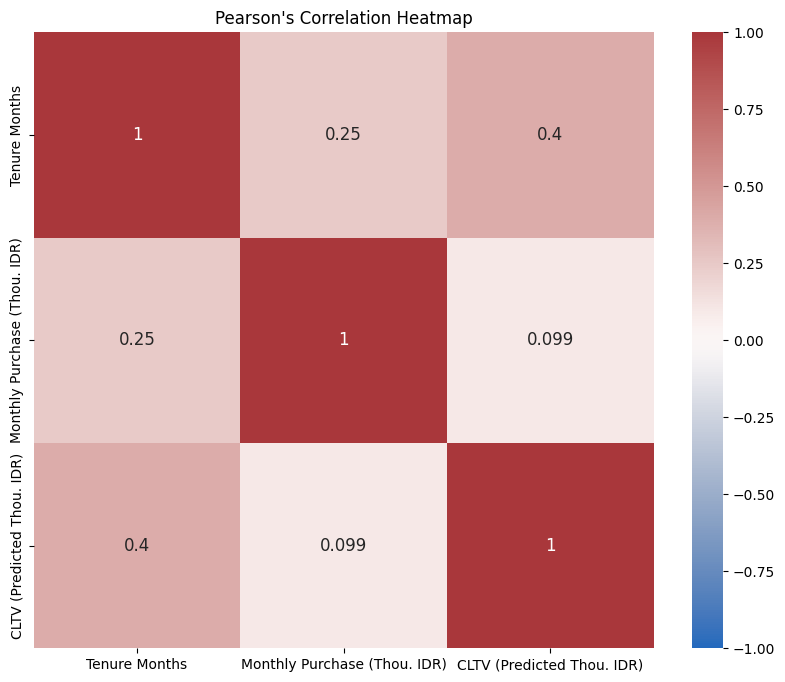

In [ ]:
# Calculate correlation matrix between numercal features
corr = df[numerical_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(corr, vmin = -1, vmax = 1, annot=True, cmap='vlag', annot_kws={"size": 12})
plt.title("Pearson's Correlation Heatmap")
plt.show()

'CLTV' and 'Monthly Purchase' features do not have correlation with one another. However, the 'Tenure Months' feature has a moderate positive correlation with 'CLTV' feature and weak positive correlation with 'Monthly Purchase' feature.

### **b. Between Categorical and Binary Features using Chi-Squared Test of Independence**

The chi-squared test of independence is used to assess whether there is a significant association or dependence between two categorical variables, which includes testing the relationship between categorical and binary variables. It determines if the observed frequencies in a contingency table deviate significantly from what would be expected if the variables were independent. This test helps evaluate if changes in one variable are related to changes in the other, making it a suitable method for analyzing the correlation or association between categorical and binary variables.

<br>

**H0: Features does not have correlation with one another** <br>
**Ha: Features have correlation with one another**<br>

<br>

We can see whether the features have correlation with one another by seeing the P-Value.

α = 0.05

If:
<ul>
  <li>P-Value < α: H0 is rejected</li>
  <li>P-Value > α: H0 is accepted</li>
</ul>

We're going to do a little bit of cleaning first to avoid bias in the correlation analysis.

In [ ]:
# Convert 'No Internet Service' category to 'No' in the selected columns
columns_to_convert = ['Games Product', 'Music Product', 'Education Product','Video Product','Use MyApp']

for column in columns_to_convert :
    df[column] = df[column].replace('No internet service', 'No')

# Transform the 'Location' column into 'is_Jakarta,' and reassign "Jakarta" to "Yes" and "Bandung" to "No."
df['is_Jakarta'] = df['Location'].apply(lambda x: 'Yes' if x == 'Jakarta' else 'No')

# Remove 'Location' column
df.drop('Location', axis=1, inplace=True)

In [ ]:
# Define Binary Features
binary_features = ['is_Jakarta', 'Games Product', 'Music Product', 'Education Product','Video Product','Use MyApp', 'Call Center', 'Churn Label']

# Remove binary features in categorical features
categorical_features = [feature for feature in categorical_features if feature not in binary_features]

# Remove 'Location' from categorical features list
categorical_features.remove('Location')

print("Binary Features:", binary_features)
print("Categorical Features:", categorical_features)

Binary Features: ['is_Jakarta', 'Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp', 'Call Center', 'Churn Label']
Categorical Features: ['Device Class', 'Payment Method']


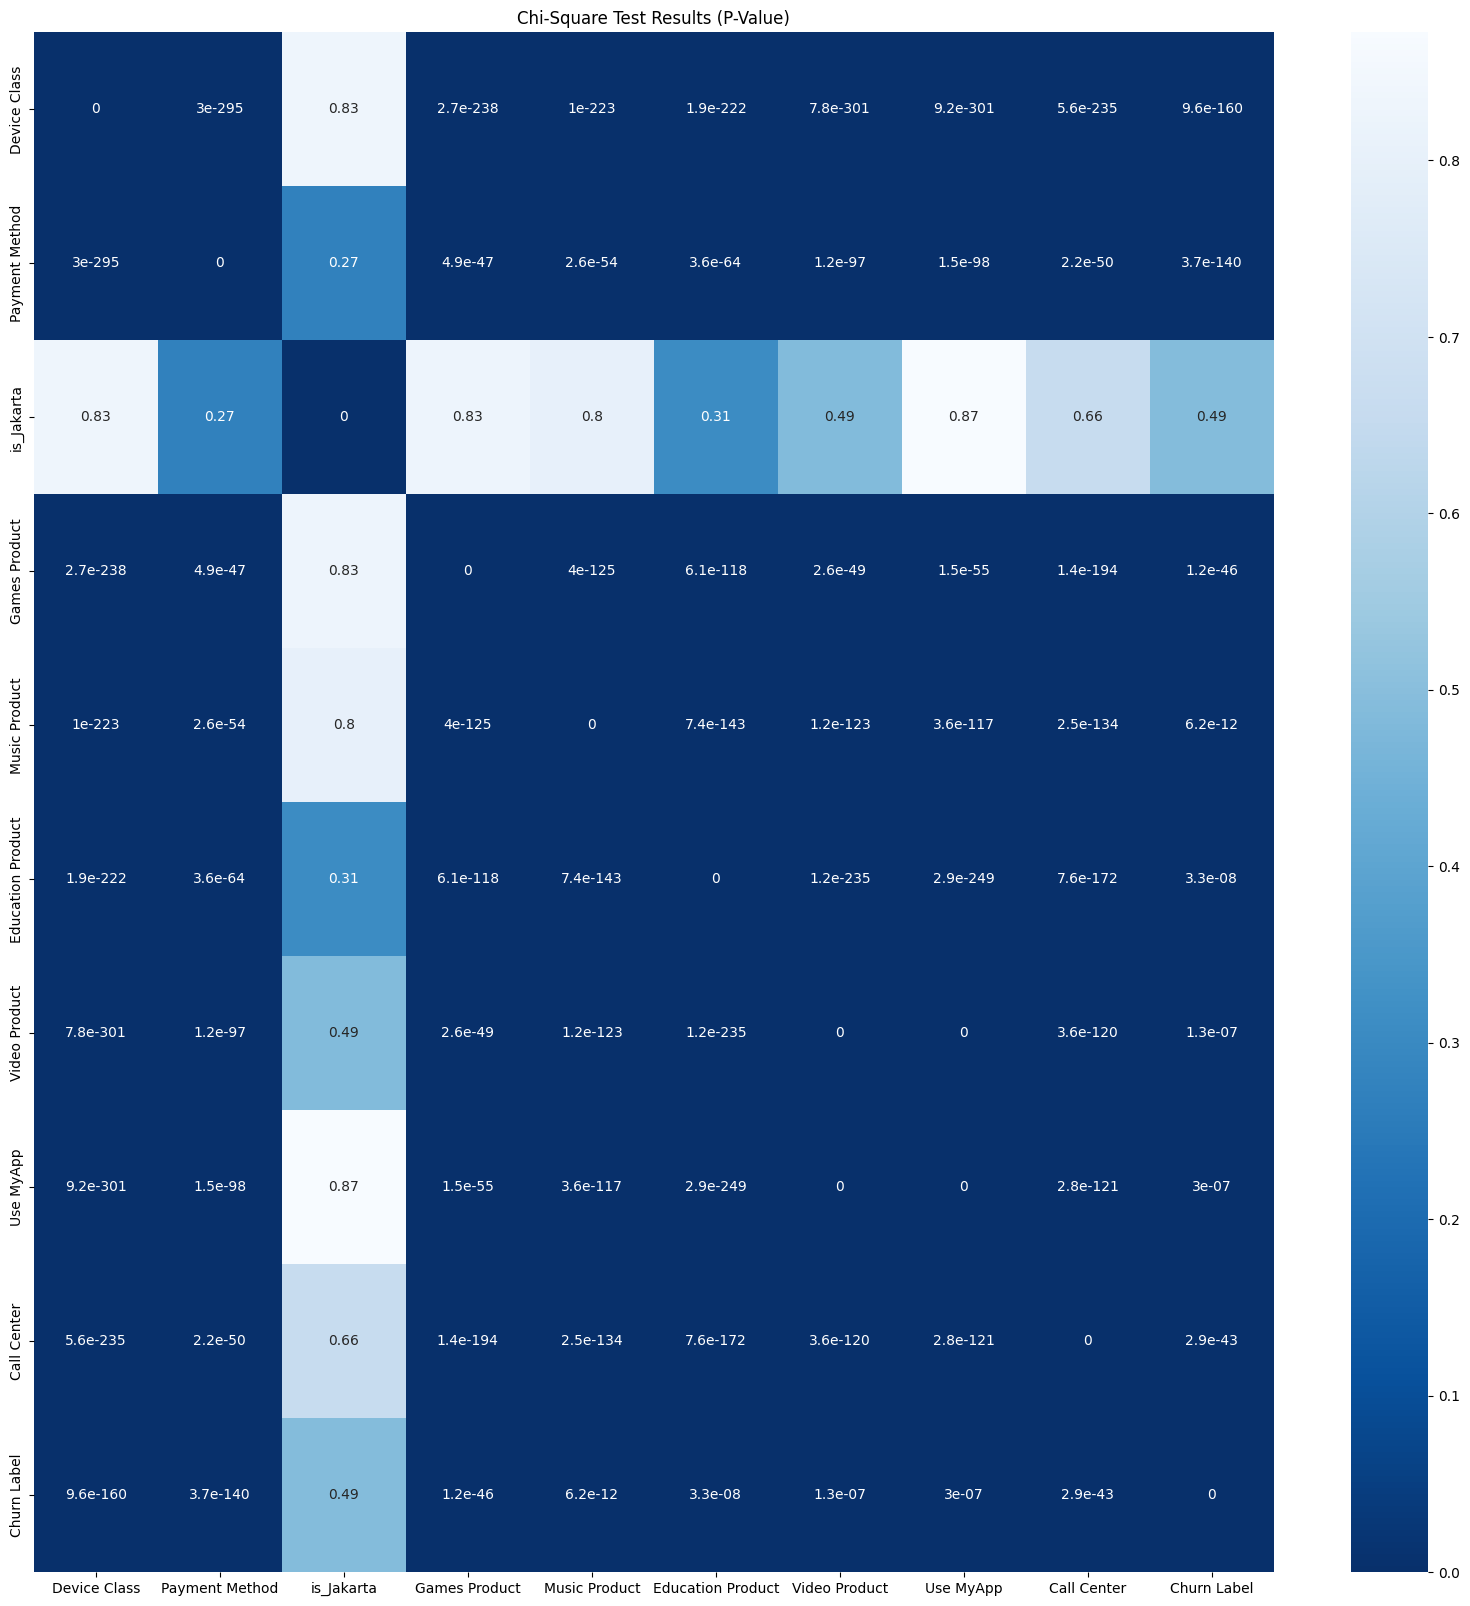

In [ ]:
# Define selected_columns
selected_columns = categorical_features + binary_features

# Initialize the result matrix
result = pd.DataFrame(data=0, columns=selected_columns, index=selected_columns)

# Finding p-value for all columns and putting them in the result matrix
for i in selected_columns:
    for j in selected_columns:
        if i != j:
            contingency_table = pd.crosstab(df[i], df[j])
            chi2_val, p_val, _, _ = chi2_contingency(contingency_table)
            result.loc[i, j] = p_val

# Plotting a heatmap
fig = plt.figure(figsize=(20, 20))
sb.heatmap(result, annot=True, cmap='Blues_r')
plt.title('Chi-Square Test Results (P-Value)')
plt.show()

All features are associated with one another except for 'is_Jakarta' feature. This feature is also does not has an association with the target variable.

### **c. Between Numerical and Categorical Features using ANOVA**

ANOVA (Analysis of Variance) is used to test the differences in means among multiple groups or categories. It is employed to assess if there are significant variations in a numerical variable across different categories within a categorical variable. In this context, ANOVA helps test the correlation or association between numerical and categorical variables. <br>
<br>
**H0: Features does not have correlation with one another**<br>
**Ha: Features have correlation with one another**<br>
<br>
We can see whether the features have correlation with one another by seeing the P-Value.

α = 0.05

If:

<ul>
  <li>P-Value < α: H0 is rejected</li>
  <li>P-Value > α: H0 is accepted</li>
</ul>

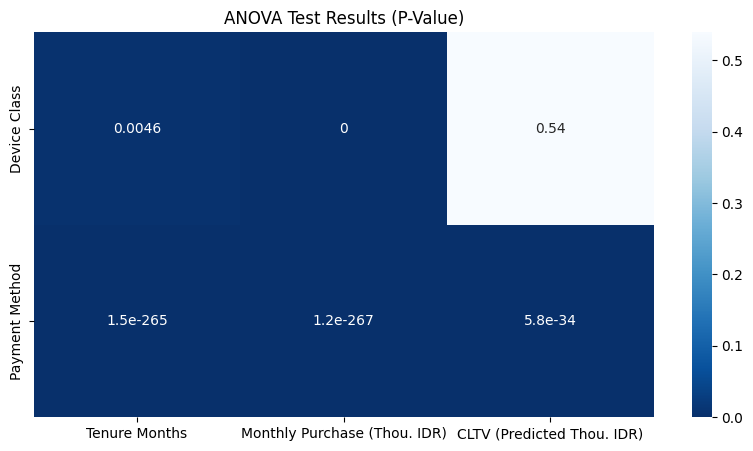

In [ ]:
from scipy.stats import f_oneway
import seaborn as sns

numeric_features = numerical_features
anova_results = {}

# Create an empty DataFrame to store the p-values
p_values_df = pd.DataFrame(index=categorical_features, columns=numeric_features, dtype=np.float64)

# Loop through each numerical feature
for num_feat in numeric_features:
    groups = []

    # Nested loop through each categorical feature
    for cat_feat in categorical_features:
        # Create a list of group data for each category in the categorical feature
        group_data = [df[num_feat][df[cat_feat] == category] for category in df[cat_feat].unique()]

        # Perform one-way ANOVA and store the result
        F, p = f_oneway(*group_data)

        # Store the p-value in the DataFrame
        p_values_df.loc[cat_feat, num_feat] = p

# Plot the p-values as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(p_values_df.astype(float), cmap='Blues_r', annot=True)
plt.title('ANOVA Test Results (P-Value)')
plt.show()

Based on the results of the ANOVA test, it's evident that all of the numerical features show correlations with the categorical features, highlighting their interrelationships. The sole exception to this observed correlation exists between 'CLTV' and 'Device Class.'

### **d. Between Numerical and Binary Features using Point Biserial**

The point-biserial test is used to assess the correlation between a numerical variable and a binary (dichotomous) variable. It quantifies the strength and direction of the relationship between a continuous numerical variable and a binary outcome variable, making it suitable for analyzing the correlation between numerical and binary variables.

<br>

**H0: Features does not have correlation with one another** <br>

**Ha: Features have correlation with one another** <br>

<br>

We can see whether the features have correlation with one another by seeing the correlation score. <br>

**Correlation Score Threshold**:
<ul>
  <li>Strong Positive Correlation: Above 0.7</li>
  <li>Moderate Positive Correlation: 0.3 to 0.7</li>
  <li>Weak Positive Correlation: 0.1 to 0.3</li>
  <li>No Linear Correlation: Around 0</li>
  <li>Weak Negative Correlation: -0.1 to -0.3</li>
  <li>Moderate Negative Correlation: -0.3 to -0.7</li>
  <li>Strong Negative Correlation: Below -0.7</li>
</ul>

**We're going to do a label encoding first** because point-biserial test need both features to be in numerical type.

In [ ]:
# Convert binary features to numerical type
for feature in binary_features:
    df[feature] = df[feature].apply(lambda x: 1 if x == 'Yes' else 0)

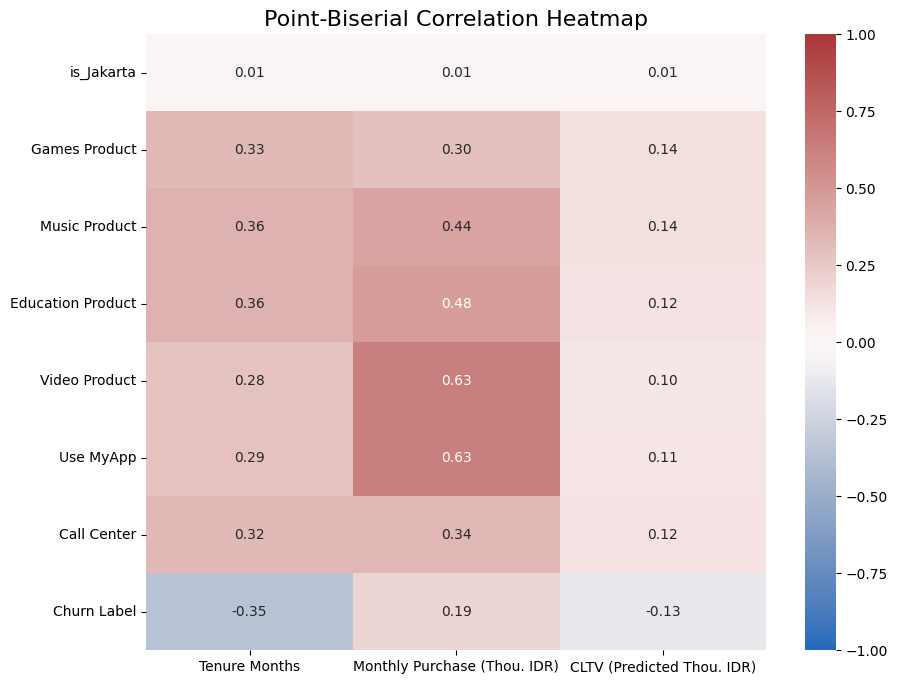

In [ ]:
# Import the necessary library
from scipy.stats import pointbiserialr
import seaborn as sns
import matplotlib.pyplot as plt

# Apply point-biserial correlation on each pair of features in the selected features
correlations = pd.DataFrame(index=numerical_features, columns=binary_features)

for i in numerical_features:
    for j in binary_features:
        if i != j:
            correlations.loc[i, j] = pointbiserialr(df[i], df[j])[0]

# Transpose the correlations DataFrame to switch the axes
correlations = correlations.T

# Visualize the correlations through a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations.astype(float), annot=True,  vmin = -1, vmax = 1, cmap="vlag", fmt=".2f")
plt.title("Point-Biserial Correlation Heatmap", fontsize=16)
plt.show()

From the Point-Biserial test above, we can see that:

<ul>
  <li>Regarding the 'Tenure Months' feature, it exhibits a weak positive correlation with 'Video Product' and 'Use MyApp', whereas it displays a moderate positive correlation with 'Games Product', 'Music Product', 'Education Product', and 'Call Center'. Additionally, a moderate negative correlation is observed with the 'Churn Label', while no correlation is found with the 'is_Jakarta' feature.</li>
  <li>As for the 'Monthly Purchase' feature, it demonstrates a weak correlation with the 'Churn Label', and showcases a moderate positive correlation with 'Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp', and 'Call Center'. Similar to 'Tenure Months', 'Monthly Purchase' exhibits no correlation with the 'is_Jakarta' feature.</li>
  <li>Turning to the 'CLTV' feature, it presents a weak negative correlation with the 'Churn Label' feature, and similarly, it exhibits no correlation with the 'is_Jakarta' feature. Notably, 'CLTV' showcases a weak positive correlation with the remaining binary features.</li>
</ul>

<br>

Interpreting the results of correlation coefficients depends on the context and the type of correlation being used. In your case, you're using point-biserial correlation, which measures the strength and direction of association between a binary variable (binary categorical features) and a numeric variable (numerical features). The point-biserial correlation coefficient can range from -1 to 1, where:

<ul>
  <li>A positive coefficient (closer to 1) indicates a positive relationship. This means that as the binary variable (e.g., 'Yes' or 'No') increases (changes), the numeric variable tends to increase as well.</li>
  <li>A negative coefficient (closer to -1) indicates a negative relationship. This means that as the binary variable increases, the numeric variable tends to decrease.</li>
  <li>A coefficient close to 0 indicates a weak or no relationship. In this case, changes in the binary variable have little impact on the numeric variable.</li>
</ul>

In the context of point-biserial correlation:

<ul>
  <li>A correlation coefficient of around 0.5 would generally be considered a strong correlation.</li>
  <li>A coefficient around 0.2 to 0.4 might be seen as a moderate correlation.</li>
  <li>Anything below 0.2 would be considered a weak or very weak correlation.</li>
</ul>

# **3. Feature Selection**

Features we aim to select, as they exhibit a moderate to high correlation with the target feature and an important feature for the business:

<ul>
  <li>'Tenure Months'</li>
  <li>'Monthly Purchase'</li>
  <li>'Device Class'</li>
  <li>'Games Product'</li>
  <li>'Music Product'</li>
  <li>'Education Product'</li>
  <li>'Call Center'</li>
  <li>'Video Product'</li>
  <li>'Use MyApp'</li>
  <li>'Payment Method'</li>
</ul>

In [ ]:
df_fs = df[['Tenure Months', 'Device Class','Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp', 'Payment Method', 'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)', 'Churn Label']]

In [ ]:
df_fs.sample(2)

,Tenure Months,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),CLTV (Predicted Thou. IDR),Churn Label
4308,4,Low End,0,0,0,0,0,0,Digital Wallet,26.065,5974.8,0
1186,23,High End,1,1,1,0,1,0,Pulsa,129.025,6939.4,1


# **4. Data Preprocessing**

## **i. Feature Engineering**

### **a. Feature Encoding**

In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
encoder = LabelEncoder()

# Fit and transform 'Device Class' column
df_fs['Device Class'] = encoder.fit_transform(df_fs['Device Class'])


# One-Hot Encoding
# Apply one-hot encoding to 'Payment Method' column
df_fs = pd.get_dummies(df_fs, columns=['Payment Method'])

<ipython-input-43-5bfa80c343f7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fs['Device Class'] = encoder.fit_transform(df_fs['Device Class'])


## **ii. Handling Class Imbalance**

In [ ]:
df_fs['Churn Label'].value_counts()

0    5174
1    1869
Name: Churn Label, dtype: int64

As we can see, the label imbalance is extreme (73.46% - 26.54%). We are going to use SMOTE Oversampling technique to handle the class imbalance. Unlike simple oversampling, which duplicates existing examples, SMOTE generates synthetic samples that are combinations of existing instances. This preserves the original information while increasing the size of the minority class.

<br>

SMOTE is not limited to specific machine learning algorithms and can be applied to various classifiers like decision trees, support vector machines, k-nearest neighbors, and more. When evaluating a model's performance on imbalanced datasets, metrics like accuracy can be misleading. SMOTE helps in creating a more balanced dataset, making it easier to use meaningful metrics like precision, recall, F1 score, or area under the ROC curve (AUC-ROC).

In [ ]:
from imblearn.over_sampling import SMOTE

# Define features and target variable
X = df_fs.drop('Churn Label', axis=1)
y = df_fs['Churn Label']

# Initialize SMOTE
smote = SMOTE(sampling_strategy='minority')

# Apply SMOTE to the data
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
y_smote.value_counts()

1    5174
0    5174
Name: Churn Label, dtype: int64

## **iii. Split Train, Test, and Validation Data**

In [ ]:
# Split the data into a training set and a temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42, stratify=y_smote)

# Split the temporary set into a validation set and a test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print('Shape of train:', '\n', 'X_train', X_train.shape, 'y_train', y_train.shape)
print('Shape of validation:', '\n', 'X_val', X_val.shape, 'y_val', y_val.shape)
print('Shape of test:', '\n', 'X_test', X_test.shape, 'y_test', y_test.shape)

Shape of train: 
 X_train (7243, 14) y_train (7243,)
Shape of validation: 
 X_val (1552, 14) y_val (1552,)
Shape of test: 
 X_test (1553, 14) y_test (1553,)


In [ ]:
y_train.value_counts()

1    3622
0    3621
Name: Churn Label, dtype: int64

In [ ]:
y_test.value_counts()

0    777
1    776
Name: Churn Label, dtype: int64

In [ ]:
y_val.value_counts()

1    776
0    776
Name: Churn Label, dtype: int64

## **iv. Data Normalization**

Normalize the distribution of skewed data. We're going to do the normalization only for numerical features.

### **a. Train**

In [ ]:
# Define scaler used
scaler = MinMaxScaler()

# Normalize the train data
X_train[['Tenure Months', 'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)']] = scaler.fit_transform(X_train[['Tenure Months', 'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)']])

X_train.sample(10)

,Tenure Months,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Monthly Purchase (Thou. IDR),CLTV (Predicted Thou. IDR),Payment Method_Credit,Payment Method_Debit,Payment Method_Digital Wallet,Payment Method_Pulsa
1646,0.027778,2,0,0,0,0,0,0,0.275536,0.591283,0,1,0,0
8028,0.625000,2,1,0,1,0,0,0,0.433786,0.146729,1,0,0,0
8234,0.083333,0,0,1,0,0,1,0,0.714062,0.812737,0,0,0,0
5700,0.319444,2,1,1,1,1,1,1,0.724464,0.886813,1,0,0,0
1472,0.013889,2,0,0,1,0,0,0,0.311410,0.741606,0,0,1,0
8959,0.013889,2,0,0,0,0,0,0,0.231323,0.303568,0,0,1,0
1852,0.416667,0,0,1,0,1,1,0,0.754360,0.723149,1,0,0,0
7399,0.083333,0,0,0,0,0,0,0,0.532274,0.311244,0,0,0,1
2296,0.152778,2,0,1,1,1,0,0,0.219233,0.028908,1,0,0,0
9836,0.027778,0,0,0,0,0,0,0,0.593577,0.596926,0,0,0,1


### **b. Test**

In [ ]:
# Normalize the test data
X_test[['Tenure Months', 'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)']] = scaler.fit_transform(X_test[['Tenure Months', 'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)']])

X_test.sample(10)

,Tenure Months,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Monthly Purchase (Thou. IDR),CLTV (Predicted Thou. IDR),Payment Method_Credit,Payment Method_Debit,Payment Method_Digital Wallet,Payment Method_Pulsa
1736,0.027778,0,0,0,0,0,0,1,0.621939,0.452503,0,1,0,0
60,0.027778,0,0,0,0,0,0,0,0.526531,0.819355,0,0,0,1
272,0.069444,2,0,0,1,0,0,1,0.211224,0.191101,0,0,0,1
6145,0.083333,0,0,1,0,0,0,1,0.685204,0.286318,0,0,1,0
8558,0.041667,2,0,0,0,0,0,0,0.319156,0.309549,0,0,0,0
5345,0.083333,2,0,1,1,1,0,0,0.221939,0.191769,0,0,1,0
7973,0.486111,2,0,0,0,0,0,0,0.378899,0.246208,0,0,0,0
8846,0.013889,0,0,0,0,0,0,0,0.598449,0.525831,0,0,0,0
5386,0.513889,2,0,0,0,0,1,0,0.173469,0.812903,1,0,0,0
178,0.055556,0,0,0,0,0,0,1,0.685204,0.808899,0,0,0,1


### c. Validation

In [ ]:
# Normalize the validation data
X_val[['Tenure Months', 'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)']] = scaler.fit_transform(X_val[['Tenure Months', 'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)']])

X_val.sample(10)

,Tenure Months,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Monthly Purchase (Thou. IDR),CLTV (Predicted Thou. IDR),Payment Method_Credit,Payment Method_Debit,Payment Method_Digital Wallet,Payment Method_Pulsa
5823,0.833333,1,0,0,0,0,0,0,0.017077,0.884307,0,0,1,0
10008,0.569444,0,0,1,1,0,1,0,0.867839,0.218433,0,0,0,0
2579,0.111111,0,0,1,0,0,0,0,0.576092,0.207312,0,0,0,1
3710,0.541667,0,0,0,0,1,1,1,0.826720,0.249666,0,0,1,0
5093,0.500000,2,0,0,1,1,0,0,0.360121,0.448729,1,0,0,0
6343,0.013889,2,1,0,0,0,0,0,0.316926,0.217120,1,0,0,0
1049,0.055556,2,0,0,0,0,0,0,0.062280,0.647570,0,0,0,1
4490,0.972222,2,1,1,1,1,1,1,0.721246,0.593402,1,0,0,0
3717,0.569444,2,1,1,1,0,1,0,0.521848,0.749220,0,0,1,0
7800,0.013889,1,0,0,0,0,0,0,0.120213,0.256071,0,0,0,0


# **5. Model Selection**

<ul>
  <li>Decision Trees: Decision trees are robust to multicollinearity because they don't rely on linear relationships between variables. They split the data based on the independent variable that provides the best split, so they can handle highly correlated features without much issue.</li>
  <li>Random Forest: Random Forests are an ensemble of decision trees, and they inherit the ability of individual decision trees to handle multicollinearity. By aggregating multiple trees, they can provide robust results even in the presence of correlated features.</li>
  <li>Support Vector Machines (SVM): SVMs can handle multicollinearity to some extent. They work well in high-dimensional spaces and can find the optimal hyperplane to separate data points, making them less sensitive to correlated features.</li>
  <li>XGBoost and Gradient Boosting Machines: Tree-based ensemble methods like XGBoost and Gradient Boosting Machines can handle multicollinearity to some extent, especially when feature selection techniques like "feature importance" are used.</li>
</ul>

In [ ]:
random_seed = 42

# Define the Classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "SVM": SVC(probability=True, random_state=random_seed),
    "XGBoost": XGBClassifier(random_state=random_seed),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed),
}

# Store the evaluation metrics in a table
results = {
    "Model": [],
    "Train F1 Score": [],
    "Validation F1 Score": [],
    "Train ROC AUC": [],
    "Validation ROC AUC": [],
    "Train Log Loss": [],
    "Validation Log Loss": []
}

# Define the parameters for K-Fold Cross Validation
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

In [ ]:
# Train and evaluate the models using k-fold cross-validation
for model_name, model in classifiers.items():
    f1_train_scores = []
    f1_validation_scores = []
    roc_auc_train_scores = []
    roc_auc_validation_scores = []
    logloss_train_scores = []
    logloss_validation_scores = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_train_fold = model.predict(X_train_fold)
        y_pred_probabilities_train_fold = model.predict_proba(X_train_fold)

        y_pred_test_fold = model.predict(X_test_fold)
        y_pred_probabilities_test_fold = model.predict_proba(X_test_fold)

        f1_train = f1_score(y_train_fold, y_pred_train_fold)
        f1_validation = f1_score(y_test_fold, y_pred_test_fold)
        roc_auc_train = roc_auc_score(y_train_fold, y_pred_probabilities_train_fold[:, 1])
        roc_auc_validation = roc_auc_score(y_test_fold, y_pred_probabilities_test_fold[:, 1])
        logloss_train = log_loss(y_train_fold, y_pred_probabilities_train_fold)
        logloss_validation = log_loss(y_test_fold, y_pred_probabilities_test_fold)

        f1_train_scores.append(f1_train)
        f1_validation_scores.append(f1_validation)
        roc_auc_train_scores.append(roc_auc_train)
        roc_auc_validation_scores.append(roc_auc_validation)
        logloss_train_scores.append(logloss_train)
        logloss_validation_scores.append(logloss_validation)

    # Calculate the mean of the performance metrics across folds
    mean_f1_train = np.mean(f1_train_scores)
    mean_f1_validation = np.mean(f1_validation_scores)
    mean_roc_auc_train = np.mean(roc_auc_train_scores)
    mean_roc_auc_validation = np.mean(roc_auc_validation_scores)
    mean_logloss_train = np.mean(logloss_train_scores)
    mean_logloss_validation = np.mean(logloss_validation_scores)

    results["Model"].append(model_name)
    results["Train F1 Score"].append(mean_f1_train)
    results["Validation F1 Score"].append(mean_f1_validation)
    results["Train ROC AUC"].append(mean_roc_auc_train)
    results["Validation ROC AUC"].append(mean_roc_auc_validation)
    results["Train Log Loss"].append(mean_logloss_train)
    results["Validation Log Loss"].append(mean_logloss_validation)

    print(f"Model: {model_name} Training and Validation finished.")

results_df = pd.DataFrame(results)

Model: Decision Tree Training and Validation finished.
Model: Random Forest Training and Validation finished.
Model: SVM Training and Validation finished.
Model: XGBoost Training and Validation finished.
Model: Gradient Boosting Training and Validation finished.


In [ ]:
results_df

,Model,Train F1 Score,Validation F1 Score,Train ROC AUC,Validation ROC AUC,Train Log Loss,Validation Log Loss
0,Decision Tree,1.000000,0.789688,1.000000,0.787401,2.220446e-16,7.668513
1,Random Forest,1.000000,0.835576,1.000000,0.917852,9.410066e-02,0.393621
2,SVM,0.842652,0.830493,0.927650,0.910016,3.615648e-01,0.384322
3,XGBoost,0.974662,0.839449,0.997159,0.922707,1.233475e-01,0.368049
4,Gradient Boosting,0.856224,0.835595,0.935591,0.920844,3.343977e-01,0.362643


# **6. Hyperparameter Tuning**

## **i. Gradient Boosting**

In [ ]:
import random
from sklearn.model_selection import cross_val_score

# Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define your objective function to optimize
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'max_features': trial.suggest_categorical('max_features', ['log2']),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.03),
        'subsample': trial.suggest_float('subsample', 0.3, 0.4),
        'n_estimators': trial.suggest_int('n_estimators', 100, 130)
    }

    # Create the Random Forest model with the sampled hyperparameters
    model = GradientBoostingClassifier(**params)

    # Perform k-fold cross-validation and calculate the F1 score
    f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

    # Calculate the mean F1 score as the metric to optimize
    f1 = f1_scores.mean()

    return f1

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximizing F1 score

# Run the optimization
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Create the best model using the best hyperparameters
best_model = GradientBoostingClassifier(random_state = 42, **best_params)

# Train the final model on the entire training dataset
best_model.fit(X_train, y_train)

# Make predictions on the validation set using the best model
y_pred = best_model.predict(X_val)

# Calculate the F1 score using the best model
best_f1 = f1_score(y_val, y_pred)
print("F1 Score with Best Hyperparameters:", best_f1)

[I 2023-11-09 12:04:45,164] A new study created in memory with name: no-name-195743d8-5396-45f7-9493-d4f88c4e8e7f
[I 2023-11-09 12:04:50,359] Trial 0 finished with value: 0.8244997143950152 and parameters: {'max_depth': 5, 'max_features': 'log2', 'learning_rate': 0.02815678704327041, 'subsample': 0.36197519838186076, 'n_estimators': 100}. Best is trial 0 with value: 0.8244997143950152.
[I 2023-11-09 12:04:52,329] Trial 1 finished with value: 0.818428023092779 and parameters: {'max_depth': 3, 'max_features': 'log2', 'learning_rate': 0.029599873201165604, 'subsample': 0.3765428006255401, 'n_estimators': 118}. Best is trial 0 with value: 0.8244997143950152.
[I 2023-11-09 12:04:54,184] Trial 2 finished with value: 0.8179846981956711 and parameters: {'max_depth': 3, 'max_features': 'log2', 'learning_rate': 0.029279748925152622, 'subsample': 0.3828668122336618, 'n_estimators': 113}. Best is trial 0 with value: 0.8244997143950152.
[I 2023-11-09 12:04:56,516] Trial 3 finished with value: 0.824

Best Hyperparameters: {'max_depth': 5, 'max_features': 'log2', 'learning_rate': 0.029099371297580057, 'subsample': 0.35634358408273914, 'n_estimators': 125}
F1 Score with Best Hyperparameters: 0.8463476070528967


Best Hyperparameter:
* 'max_depth': 5
* 'max_features': 'log2'
* 'learning_rate': 0.029099371297580057
* 'subsample': 0.35634358408273914
* 'n_estimators': 125

Train F1 Score: 0.8324307195195303

Validation F1 Score: 0.8463476070528967

### **a. Gradient Boosting Parameter**

In [ ]:
# Define the hyperparameters for the Gradient Boosting
gb_params = {'max_depth': 5,
          'max_features': 'log2',
          'learning_rate': 0.029,
          'subsample': 0.356,
          'n_estimators': 125}

# Create the Gradient Boosting classifier with the specified hyperparameters
gb_model = GradientBoostingClassifier(random_state=42, **gb_params)

### **b. Learning Curve**

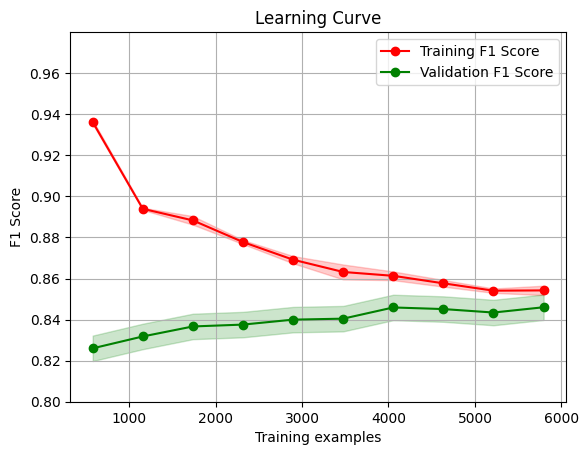

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score

# Compute the learning curve using the training data
train_sizes, train_scores, _ = learning_curve(
    gb_model, X_train, y_train, cv=5, scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation F1 score at each training set size
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# Evaluate the model on the validation data
val_scores = [f1_score(y_val, gb_model.fit(X_train[:int(size * len(X_train))], y_train[:int(size * len(X_train))]).predict(X_val)) for size in np.linspace(0.1, 1.0, 10)]

# Calculate the validation standard deviation F1 score
val_scores_std = np.std(val_scores)

# Determine the y-axis limits
y_min = 0.80 # round(min(min(train_scores_mean), min(val_scores) - 0.03), 2)
y_max = 0.98 # round(max(max(train_scores_mean), max(val_scores) + 0.1), 2)


# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.ylim(y_min, y_max)  # Set the y-axis limits
plt.yticks(np.arange(y_min, y_max, 0.02))  # Set y-axis ticks with 0.05 gaps
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training F1 Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(train_sizes, val_scores, 'o-', color="g", label="Validation F1 Score")
plt.fill_between(train_sizes, val_scores - val_scores_std, val_scores + val_scores_std, alpha=0.2, color="g")

plt.legend(loc="best")
plt.show()

### **c. Bias Variance Trade Off**

In [ ]:
from mlxtend.evaluate import bias_variance_decomp

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        gb_model, X_train.values, y_train.values, X_val.values, y_val.values,
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.160
Average bias: 0.155
Average variance: 0.031


In [ ]:
# Fitting the model
gb_model.fit(X_train, y_train)

# Predict probabilities for each class
pred_prob_gb = gb_model.predict_proba(X_val)[:, 1]

# Calculate log loss for Gradient Boosting
log_loss_gb = log_loss(y_val, pred_prob_gb)

print('Validation Log Loss:', log_loss_gb)

Validation Log Loss: 0.38312186365662076


# **7. Model Evaluation**

After diligent experimentation with various methods and numerous iterations, we have achieved our best parameters and scores using the Optuna library.

Please note that we are unable to display the results obtained from running the code, as the Optuna library produces random outputs with each execution.

In [ ]:
# Combining train and validation data
X_train_and_val = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_train_and_val = pd.concat([y_train, y_val], ignore_index=True)

In [ ]:
y_train_and_val.value_counts()

1    4398
0    4397
Name: Churn Label, dtype: int64

## **i. Model Fitting**

In [ ]:
from sklearn.metrics import roc_curve, auc

# Set random seeds for reproducibility
np.random.seed(42)
random_state = 42

# Gradient Boosting model with best hyperparameters
gb_model = GradientBoostingClassifier(random_state=random_state, **gb_params)
gb_model.fit(X_train_and_val, y_train_and_val)

# Predict probabilities
pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, pred_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Calculate test F1 score for Gradient Boosting
predicted_labels_gb = gb_model.predict(X_test)
f1_score_gb = f1_score(y_test, predicted_labels_gb)

# Calculate log loss for Gradient Boosting
log_loss_gb = log_loss(y_test, pred_prob_gb)

print(f"Gradient Boosting Test F1 Score: {f1_score_gb:.4f}")
print(f"Gradient Boosting Log Loss: {log_loss_gb:.4f}")

Gradient Boosting Test F1 Score: 0.8353
Gradient Boosting Log Loss: 0.3812


## i**i. Area Under ROC Curve**

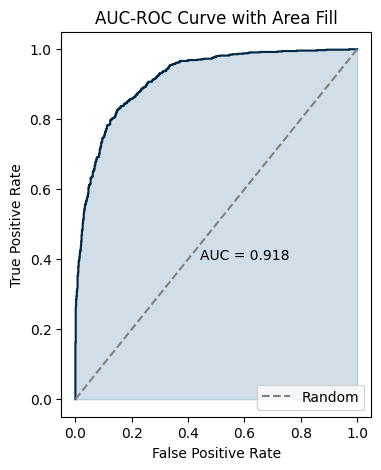

In [ ]:
plt.figure(figsize=(4,5))

# Plot Gradient Boosting ROC curve
plt.plot(fpr_gb, tpr_gb, color='#002845')
plt.fill_between(fpr_gb, tpr_gb, alpha=0.2, color='#1a5e8f')

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Annotate the AUC score inside the plot
plt.annotate(f'AUC = {roc_auc_gb:.3f}', xy=(0.6, 0.2), xytext=(0.6, 0.4),
             fontsize=10, color='black', ha='center')

# Set labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve with Area Fill')
plt.legend()
plt.show()

## **iii. Confusion Matrix**

Hyperparameters: {'max_depth': 5, 'max_features': 'log2', 'learning_rate': 0.029, 'subsample': 0.356, 'n_estimators': 125}
F1 Score (Training and Validation): 0.8346545526918472
F1 Score (Test): 0.831532104259377
ROC AUC Score (Training and Validation): 0.9136565311821284
ROC AUC Score (Test): 0.9183119054253074
Log Loss (Training and Validation): 0.3877951117736768
Log Loss (Test): 0.38067470319504265


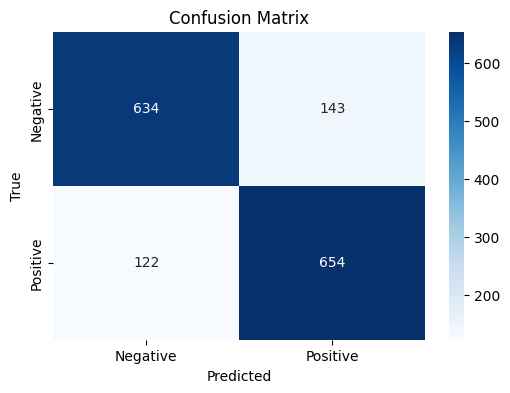

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Set a random seed for reproducibility
np.random.seed(42)
random_state = 42

# Predictions on the training and validation set
y_train_and_val_pred = gb_model.predict(X_train_and_val)
y_train_and_val_probabilities = gb_model.predict_proba(X_train_and_val)

# Make predictions on your test data
y_test_pred = gb_model.predict(X_test)
y_test_probabilities = gb_model.predict_proba(X_test)

# Calculate F1 score for training and validation set using 5-fold cross-validation
f1_train_and_val = cross_val_score(gb_model, X_train_and_val, y_train_and_val, cv=5, scoring='f1').mean()

# Calculate ROC AUC score for training and validation set using 5-fold cross-validation
roc_auc_train_and_val = cross_val_score(gb_model, X_train_and_val, y_train_and_val, cv=5, scoring='roc_auc').mean()

# Calculate log loss for training and validation set using 5-fold cross-validation
log_loss_train_and_val = -cross_val_score(gb_model, X_train_and_val, y_train_and_val, cv=5, scoring='neg_log_loss').mean()

# Calculate F1 score for the test set
f1_test = f1_score(y_test, y_test_pred)

# Calculate ROC AUC score for the test set
roc_auc_test = roc_auc_score(y_test, y_test_probabilities[:, 1])

# Calculate log loss for the test set
log_loss_test = log_loss(y_test, y_test_probabilities)

# Print the results
print("Hyperparameters:", gb_params)
print("F1 Score (Training and Validation):", f1_train_and_val)
print("F1 Score (Test):", f1_test)
print("ROC AUC Score (Training and Validation):", roc_auc_train_and_val)
print("ROC AUC Score (Test):", roc_auc_test)
print("Log Loss (Training and Validation):", log_loss_train_and_val)
print("Log Loss (Test):", log_loss_test)

# Generate the confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix for visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## **iv. Feature Importance**

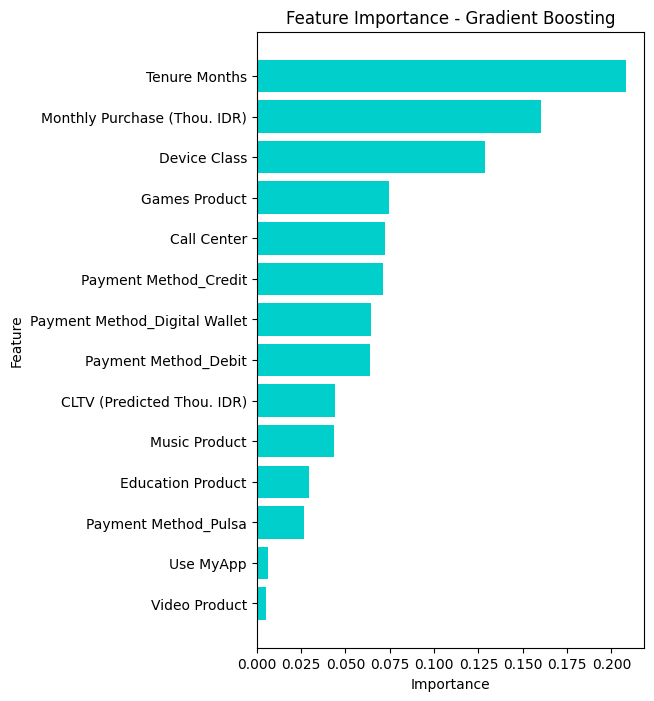

In [ ]:
# Get feature importances
feature_importances = gb_model.feature_importances_

# Get feature names if available
feature_names = X_train_and_val.columns if hasattr(X_train, 'columns') else range(len(feature_importances))

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::1]

# Plot feature importances horizontally
plt.figure(figsize=(5,8))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], color='#00cfcc')
plt.yticks(range(len(feature_importances)), feature_names[sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Gradient Boosting')
plt.show()

## **v. SHAP Values**

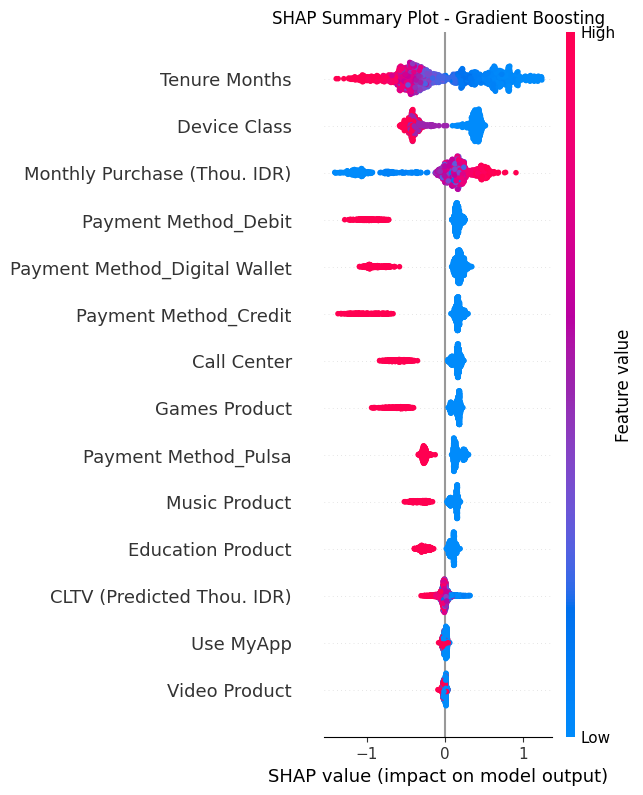

In [ ]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(gb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Summary Plot - Gradient Boosting')
plt.gcf().set_size_inches(5, 8)
plt.show()

<ul>
  <li>Tenure Months: Higher value of tenure months leads to a lower chance of churn. Lower value of tenure months leads to a higher chance of churn.</li>
  <li>Device Class: Higher value of device class leads to a lower chance of churn. Lower value of device months leads to a higher chance of churn.</li>
  <li>Monthly Purchase (Thoud.IDR): Lower value of monthly purchase (in Thou. IDR) leads to a lower chance of churn. Higher value of monthly purchase (in Thou. IDR) leads to a higher chance of churn.</li>
</ul>

# **8. Business Simulation**

In [ ]:
# Assuming X_test and y_test are pandas dataframes or series
# Convert y_test to a dataframe if it's a series
if isinstance(y_test, pd.Series):
    y_test = y_test.to_frame(name='Churn Label')

# Combine X_test and y_test
combined_test = pd.concat([X_test, y_test], axis=1)

combined_test.sample(3)

,Tenure Months,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Monthly Purchase (Thou. IDR),CLTV (Predicted Thou. IDR),Payment Method_Credit,Payment Method_Debit,Payment Method_Digital Wallet,Payment Method_Pulsa,Churn Label
6760,0.875000,1,0,0,0,0,0,0,0.054857,0.654950,0,0,1,0,0
8288,0.055556,0,0,0,0,0,0,0,0.621161,0.520195,0,0,0,1,1
4383,0.888889,0,1,0,0,1,0,0,0.690798,0.647608,0,1,0,0,0


In [ ]:
churn_test = combined_test[combined_test['Churn Label'] == 1]
not_churn_test = combined_test[combined_test['Churn Label'] == 0]

total_cust = len(combined_test)
total_churn = len(churn_test)
total_not_churn = len(not_churn_test)

print("Total Customer:", total_cust)
print("Total Churn:", total_churn)
print("Total Not Churn:", total_not_churn)

Total Customer: 1553
Total Churn: 776
Total Not Churn: 777


In [ ]:
churn_cltv_med = round((churn_test['CLTV (Predicted Thou. IDR)'].median())*10000)*1000
not_churn_cltv_med = round((not_churn_test['CLTV (Predicted Thou. IDR)'].median())*10000)*1000

print("Churn Median CLTV:", churn_cltv_med)
print("Not Churn Median CLTV:", not_churn_cltv_med)

Churn Median CLTV: 4891000
Not Churn Median CLTV: 5991000


In [ ]:
# Define factors

# Cost
marketing_cost = 10000
discount_cost = 30000

# Rate of Promo Acceptance (RPA)
churn_rpa = 0.5
not_churn_rpa = 0.75

# Rate of Annoyance (RoA)
roa = 0.1

# Confusion Matrix
true_neg = conf_matrix[0][0]
true_pos = conf_matrix[1][1]
false_neg = conf_matrix[1][0]
false_pos = conf_matrix[0][1]

In [ ]:
# Without Model

# Cost
without_churn_marketing = marketing_cost*total_churn
without_churn_discount = (churn_rpa*total_churn)*discount_cost
without_not_churn_marketing = marketing_cost*total_not_churn
without_not_churn_discount = (not_churn_rpa*total_not_churn)*discount_cost

without_total_cost = without_churn_marketing + without_churn_discount + without_not_churn_marketing + without_not_churn_discount

# CLTV Loss
without_cltv_loss_churn = (churn_rpa*total_churn)*churn_cltv_med
without_cltv_loss_not_churn = (roa*total_not_churn)*not_churn_cltv_med

without_total_cltv_loss = without_cltv_loss_churn + without_cltv_loss_not_churn

# CLTV Retain
without_cltv_retain_churn = ((1-churn_rpa)*total_churn)*churn_cltv_med
without_cltv_retain_not_churn = ((1-roa)*total_not_churn)*not_churn_cltv_med

without_total_cltv_retain = without_cltv_retain_churn + without_cltv_retain_not_churn


# With Model

# Cost
with_churn_marketing = marketing_cost*true_pos
with_churn_discount = (churn_rpa*true_pos)*discount_cost
with_not_churn_marketing = marketing_cost*false_pos
with_not_churn_discount = (not_churn_rpa*false_pos)*discount_cost

with_total_cost = with_churn_marketing + with_churn_discount + with_not_churn_marketing + with_not_churn_discount

# CLTV Loss
with_cltv_loss_churn = ((churn_rpa*true_pos) + false_neg)*churn_cltv_med
with_cltv_loss_not_churn = (roa*false_pos)*not_churn_cltv_med

with_total_cltv_loss = with_cltv_loss_churn + with_cltv_loss_not_churn

# CLTV Retain
with_cltv_retain_churn = ((1-churn_rpa)*true_pos)*churn_cltv_med
with_cltv_retain_not_churn = (((1-roa)*(false_pos)) + (true_neg))*not_churn_cltv_med

with_total_cltv_retain = with_cltv_retain_churn + with_cltv_retain_not_churn

print(f"Without Model:\nTotal Cost: {without_total_cost}\nCLTV Loss: {without_total_cltv_loss}\nCLTV Retain: {without_total_cltv_retain}\n")
print(f"With Model:\nTotal Cost: {with_total_cost}\nCLTV Loss: {with_total_cltv_loss}\nCLTV Retain: {with_total_cltv_retain}")

Without Model:
Total Cost: 44652500.0
CLTV Loss: 2363208700.0
CLTV Retain: 6087214300.0

With Model:
Total Cost: 20997500.0
CLTV Loss: 2281730300.0
CLTV Retain: 6168692700.0


In [ ]:
# Percentage of Reduction of Churn Customer Without Model


without_total_real_churn = round((churn_rpa*total_churn) + (roa*total_not_churn))

without_churn_reduc = ((total_churn - without_total_real_churn) / total_churn) * 100

print("Without model we can reduce churn until", round(without_churn_reduc,2),'%')

Without model we can reduce churn until 39.95 %


In [ ]:
# Percentage Reduction of Churn Customer

# Total customer that churn after tratment
with_total_real_churn = round(false_neg + (churn_rpa*true_pos) + (roa*false_pos))

with_churn_reduc = ((total_churn - with_total_real_churn) / total_churn) * 100

print("This model can reduce churn until", round(with_churn_reduc,2),'%')

This model can reduce churn until 40.34 %


# **9. Machine Learning Model Web App**


After the completion of model training and evaluation, the concluding phase involves deploying the model through the utilization of Streamlit and version control system of Github.

In [ ]:
import pickle

gbc_model_filtered = GradientBoostingClassifier(max_depth=5, max_features='log2', learning_rate=0.029, subsample=0.356, n_estimators=125, random_state=42)
gbc_model_filtered.fit(X_train_and_val, y_train_and_val)

filename = 'Data_Porter_Customer_Churn_Prediction.sav'
pickle.dump(gbc_model_filtered, open(filename, 'wb'))